## Case Fraude 

O problema das fraudes em cartões de crédito é uma das principais preocupações das instituições financeiras, já que essas fraudes podem causar **prejuízos significativos** para os consumidores e para as próprias instituições. Além disso, a detecção de fraudes pode ser um desafio, já que os fraudadores estão constantemente buscando maneiras de evadir os sistemas de segurança. Segundo dados da Serasa Experian, apenas no Brasil, cerca de **12,1 milhões de pessoas foram vítimas** de algum tipo de **fraude financeira** no último ano, representando um **prejuízo de 1,8 bilhão de reais** para os últimos 12 meses.

Detectar fraudes em cartões de crédito pode ser um desafio, já que as transações legítimas e as fraudulentas podem se parecer muito entre si. Além disso, as fraudes podem ocorrer em uma ampla gama de valores e locais, tornando difícil identificar um padrão. Isso pode levar a erros de detecção, tanto em falsos positivos (bloqueio preventivo do cartão do consumidor) quanto em falsos negativos (não detecção de uma transação fraudulenta).

<center>
<img src = "https://github.com/danielesantiago/FraudClassifier/blob/master/Arquivos/fraud.jpg?raw=true" width = "60%">
<a href="https://www.freepik.com/free-vector/cyber-fraud-with-desktop_60926711.htm#query=fraud&position=40&from_view=search&track=sph">Image by studiogstock</a> on Freepik
</center>

O objetivo deste projeto é realizar uma **análise exploratória dos dados** e construir **modelos de machine learning** capazes de **detectar transações fraudulentas com alta precisão**. Para isso, será necessário utilizar técnicas avançadas de análise de dados e machine learning para identificar padrões e anomalias nos dados, bem como técnicas de balanceamento de dados. Além disso, será importante avaliar a eficácia dos modelos construídos, tanto em termos de precisão na detecção de fraudes quanto em relação à quantidade de falsos positivos.

### Business Understanding

A fraude em transações é um ato de adquirir bens e serviços utilizando informações de pagamento roubadas. À medida que a adoção do cartão de crédito cresce, tanto em compras online quanto presenciais, as fraudes associadas a ele também se intensificam. É essencial para as empresas compreenderem esta ameaça, seus tipos e as métricas para monitorar e combater efetivamente tais atividades.

**Tipos de Fraude**:
1. **Fraude de Cartão de Crédito**: 
   - *Offline*: Usa-se um cartão físico roubado em locais como call centers.
   - *Online*: Ocorre na internet, telefone ou outros meios digitais sem a presença física do cartão.
   
2. **Fraude em Telecomunicações**: Uso indevido de serviços de telecomunicações para cometer fraudes. Pode afetar consumidores, empresas e provedores de serviços.

3. **Fraude em Computadores**: Inclui intrusões não autorizadas em sistemas para obter dados ou causar danos.

4. **Outros Tipos**:
   - Fraude de Falência
   - Fraude de Furto/Contrafação
   - Fraude de Aplicação
   - Fraude Comportamental

**Principais KPIs (Indicadores Chave de Desempenho) de Fraude**:
1. **Aceitação**: Volume de transações aceitas após autorização e triagem.
2. **Desafios**: Transações potencialmente fraudulentas que são sinalizadas para revisão manual.
3. **Negações**: Solicitações de pagamento rejeitadas pelo adquirente ou identificadas como fraude antes do processamento.
4. **Chargebacks**: Transações que o adquirente identifica como fraude ou que o cliente contesta.
5. **Falsos Positivos**: Transações legítimas de clientes bloqueadas incorretamente como fraude.

Para um desempenho eficaz de gerenciamento de fraudes, é fundamental monitorar todos esses KPIs. Taxas elevadas de falsos positivos, por exemplo, podem resultar em vendas perdidas e clientes frustrados. Portanto, além de se proteger contra fraudes, as empresas devem garantir que suas soluções de detecção de fraudes não afastem clientes legítimos.

**Métricas de Business**:
Para esse projeto, sabe-se que a empresa ganha 10% do valor de um pagamento corretamente aprovado e perde 100% em caso de fraude:
- **Taxa de Fraude** = ($ transações fraudulentas aprovadas) / ($ transações totais aprovadas)
- **Taxa de Aprovação** = ($ transações totais aprovadas) / ($ transações recebidas)

### Importando os pacotes necessários

In [1]:
# Bibliotecas padrão
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow 

# Visualização de dados
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import missingno

# Testes estatísticos
from scipy.stats import chi2_contingency, mannwhitneyu

# Modelos de machine learning e utilitários
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import (roc_curve, auc, confusion_matrix, log_loss, roc_auc_score,
                             precision_score, recall_score, f1_score, make_scorer)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import category_encoders as ce

# Classificadores e métodos de ensemble
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel("Arquivos/dados.xlsx")

## **Análise dos Dados**

Esta seção fornece uma visão detalhada da estrutura e do significado dos dados que estão sendo analisados.

#### **Dicionário de Variáveis**

- **`score_1` a `score_10`**: 
  - Descrição: Notas de bureau de crédito.
  - Finalidade: Utilizadas para avaliar a confiabilidade do comprador.
  
- **`Pais`**: 
  - Descrição: País onde a compra foi realizada.

- **`Produto`**: 
  - Descrição: Item específico adquirido no e-commerce.

- **`Categoria_produto`**: 
  - Descrição: Classificação do produto dentro do e-commerce.

- **`Entrega_doc_1` a `entrega_doc_3`**: 
  - Descrição: Indicadores de entrega de documentos no momento de criação da conta.
  - Valores: 
    - **0** ou **N**: Não entregou.
    - **1** ou **Y**: Entregou.
    - Vazio: Considerei como não entregou.

- **`Score_fraude_modelo`**: 
  - Descrição: Probabilidade, fornecida pelo modelo atual, de uma compra ser fraudulenta.
  - Valores: Varia de 0 a 100. Quanto mais próximo de 100, maior a confiança do modelo de que a transação é fraudulenta.

- **`Fraude`**: 
  - Descrição: Verificação de autenticidade da compra.
  - Valores: 
    - **0**: Transação legítima.
    - **1**: Transação fraudulenta.
  - Observação: Esta informação é confirmada alguns dias após a transação para garantir precisão.



### Análise exploratória dos dados

In [3]:
# Ver as cinco primeiras entradas
df.head()

,score_1,score_2,score_3,score_4,score_5,score_6,pais,score_7,produto,categoria_produto,score_8,score_9,score_10,entrega_doc_1,entrega_doc_2,entrega_doc_3,data_compra,valor_compra,score_fraude_modelo,fraude
0,4,0.7685,94436.24,20.0,0.444828,1.0,BR,5,Máquininha Corta Barba Cabelo Peito Perna Pelo...,cat_8d714cd,0.883598,240.0,102.0,1,NaN,N,2020-03-27 11:51:16,5.64,66,0
1,4,0.7550,9258.50,1.0,0.000000,33.0,BR,0,Avental Descartavel Manga Longa - 50 Un. Tnt ...,cat_64b574b,0.376019,4008.0,0.0,1,Y,N,2020-04-15 19:58:08,124.71,72,0
2,4,0.7455,242549.09,3.0,0.000000,19.0,AR,23,Bicicleta Mountain Fire Bird Rodado 29 Alumini...,cat_e9110c5,0.516368,1779.0,77.0,1,NaN,N,2020-03-25 18:13:38,339.32,95,0
3,4,0.7631,18923.90,50.0,0.482385,18.0,BR,23,Caneta Delineador Carimbo Olho Gatinho Longo 2...,cat_d06e653,0.154036,1704.0,1147.0,1,NaN,Y,2020-04-16 16:03:10,3.54,2,0
4,2,0.7315,5728.68,15.0,0.000000,1.0,BR,2,Resident Evil Operation Raccoon City Ps3,cat_6c4cfdc,0.855798,1025.0,150.0,1,NaN,N,2020-04-02 10:24:45,3.53,76,0


É possível notar que:
* Algumas variáveis estão anônimas, para garantir a privacidade do usuário.
* Há variável contendo texto, em `produto`.
* `entrega_doc_2`possui valores nulos.
* Possuímos a data e hora da compra na feature `data_compra`.
* `score_fraude_modelo` é o score do modelo anterior que servirá de baseline, e não deve entrar nas features do modelo novo.

In [4]:
# Visualizar o tamanho do dataframe
print(f"Entradas: {df.shape[0]}")
print(f"Colunas: {df.shape[1]}")

Entradas: 150000
Colunas: 20


In [5]:
# Extrair nome das colunas
df.columns

Index(['score_1', 'score_2', 'score_3', 'score_4', 'score_5', 'score_6',
       'pais', 'score_7', 'produto', 'categoria_produto', 'score_8', 'score_9',
       'score_10', 'entrega_doc_1', 'entrega_doc_2', 'entrega_doc_3',
       'data_compra', 'valor_compra', 'score_fraude_modelo', 'fraude'],
      dtype='object')

In [6]:
# Extrair o tipo das variáveis
df.dtypes

score_1                         int64
score_2                       float64
score_3                       float64
score_4                       float64
score_5                       float64
score_6                       float64
pais                           object
score_7                         int64
produto                        object
categoria_produto              object
score_8                       float64
score_9                       float64
score_10                      float64
entrega_doc_1                   int64
entrega_doc_2                  object
entrega_doc_3                  object
data_compra            datetime64[ns]
valor_compra                  float64
score_fraude_modelo             int64
fraude                          int64
dtype: object

In [7]:
# Porcentagem de itens nulos
(df.isnull().sum()/df.shape[0] * 100).round(2)

score_1                 0.00
score_2                 8.66
score_3                 8.66
score_4                 0.24
score_5                 0.00
score_6                 0.01
pais                    0.13
score_7                 0.00
produto                 0.00
categoria_produto       0.00
score_8                 0.00
score_9                 0.01
score_10                0.24
entrega_doc_1           0.00
entrega_doc_2          72.57
entrega_doc_3           0.00
data_compra             0.00
valor_compra            0.00
score_fraude_modelo     0.00
fraude                  0.00
dtype: float64

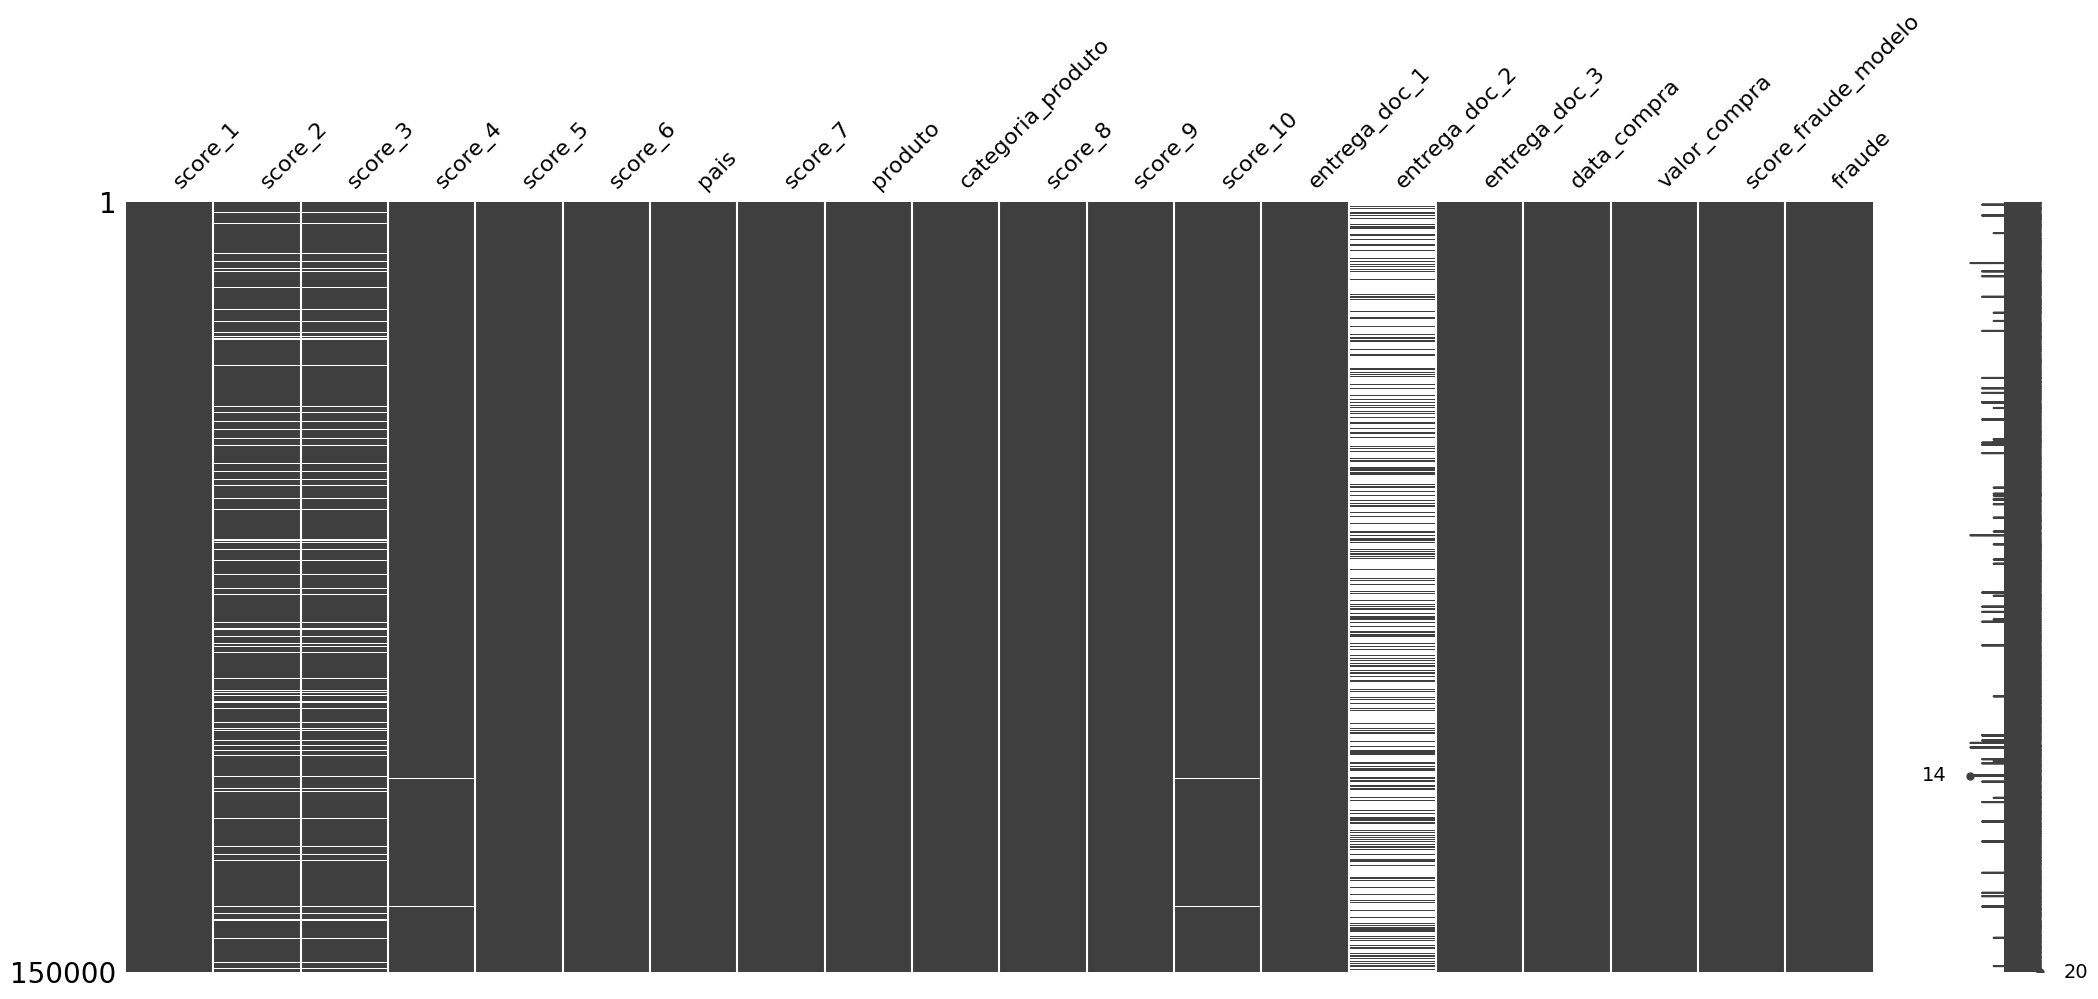

In [8]:
missingno.matrix(df);

`entrega_doc_2` como vislumbrado anteriormente possui 72% dos itens nulos. O nulo, neste caso, pode representar pessoas que não entregaram os documentos. porém essa falta de entrega pode ajudar a detectar possiveis fraudadores. Nesses casos, é interessante criar uma nova feature (coluna) booleana indicando se o documento foi ou não entregue (1: entregue, 0: preenchimento nulo).


### ANÁLISE EXPLORATÓRIA (EDA) UNIVARIADA

A variável `score_1` é categórica, iremos analisar a quantidade de usuários por categoria.

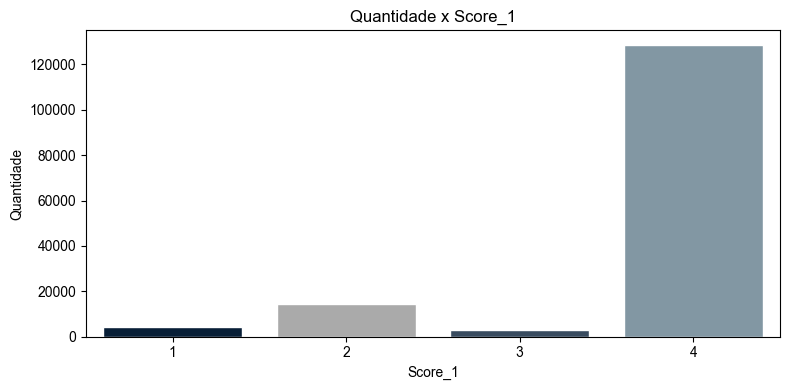

In [9]:
fig, ax = plt.subplots(figsize = (8, 4))
sns.set_style("darkgrid", {"grid.color": ".5", "grid.linestyle": ":"})
# Definindo a paleta de cores
colors = ["#001F3F", "#AAAAAA", "#334C66", "#7D99A8", "#D0D0D0"]
sns.set_palette(sns.color_palette(colors))
count = df.score_1.value_counts
sns.countplot(x='score_1', data = df)
ax.set_xlabel("Score_1")
ax.set_ylabel("Quantidade")
ax.set_title("Quantidade x Score_1")
plt.tight_layout();

É possível observar que a maioria dos usuários está contida na categoria 4.

Veremos agora a cardinalidade da variável `país`.

In [10]:
df.pais.value_counts()

BR    111628
AR     31964
UY      2967
US      2273
SE       358
MX       236
RU        73
ES        69
CO        64
GB        43
FR        18
IT        14
PT        13
DE         9
CL         9
PE         5
EC         4
PY         4
AU         3
PA         3
CA         3
UA         3
BE         3
CN         3
CH         3
NZ         3
PR         2
NL         2
BO         2
CR         2
AE         2
LB         2
FI         1
TW         1
NO         1
EG         1
IL         1
PH         1
JP         1
GH         1
NI         1
DO         1
BS         1
TR         1
IN         1
GR         1
HN         1
KR         1
GE         1
AD         1
ZA         1
Name: pais, dtype: int64

In [11]:
(df.pais.value_counts()/df.shape[0] * 100).round(2)

BR    74.42
AR    21.31
UY     1.98
US     1.52
SE     0.24
MX     0.16
RU     0.05
ES     0.05
CO     0.04
GB     0.03
FR     0.01
IT     0.01
PT     0.01
DE     0.01
CL     0.01
PE     0.00
EC     0.00
PY     0.00
AU     0.00
PA     0.00
CA     0.00
UA     0.00
BE     0.00
CN     0.00
CH     0.00
NZ     0.00
PR     0.00
NL     0.00
BO     0.00
CR     0.00
AE     0.00
LB     0.00
FI     0.00
TW     0.00
NO     0.00
EG     0.00
IL     0.00
PH     0.00
JP     0.00
GH     0.00
NI     0.00
DO     0.00
BS     0.00
TR     0.00
IN     0.00
GR     0.00
HN     0.00
KR     0.00
GE     0.00
AD     0.00
ZA     0.00
Name: pais, dtype: float64

In [12]:
len(df.pais.unique())

52

Há 52 países no dataset, onde Brasil e Argentina representam mais de 90% do dataset.

Vejamos agora em relação à feature `produto`.

In [13]:
df.produto.value_counts()

Fone De Ouvido Sem Fio Xiaomi Airdots Preto                     83
Xiaomi Redmi Note 8 Dual Sim 64 Gb Azul-netuno 4 Gb Ram         51
Clean Sept - Álcool Em Gel 70% 500 Ml                           49
Tapete Ilustrativo Pista Carrinho Hot Wheels 0,60x1,20m         47
Máscara Descartável Tripla Com Elástico Proteção Anvisa 50un    47
                                                                ..
Bateria Zetta, Nova, Com Nota Fiscal, 12 Mês De Garantia         1
Dispenser Jabón Liquido / Alcohol En Gel X Unidad                1
Moletom Gola Redonda Shawn Mendes Top 98 Unissex Promoção        1
Placa Interface Adesivo Lavadora Brastemp Bwl11 Emicol Biv.      1
A Magia Divina Das Velas. O Livro Das Sete Chamas Sagradas       1
Name: produto, Length: 127804, dtype: int64

In [14]:
len(df.produto.unique())

127804

A alta cardinalidade pode ser muito prejudicial para o modelo pois existem grandes chances dessas determinadas features não discriminarem padrões, e, portanto, não agregar nada ao modelo. Além disso, a alta cardinalidade pode deixar os dados muito esparsos, afetando a performance do modelo


A fim de entender melhor e adquirir uma intuição, plotarei uma nuvem de palavras para `produto`.

In [15]:
# ver a quantidade de valores ausentes
print("Valores ausentes para produto: ", df.produto.isnull().sum())

# eliminar as colunas com valores ausentes
produto = df.dropna(subset=['produto'], axis=0)['produto']

Valores ausentes para produto:  0


In [16]:
# Concatenar todas as descrições de produtos em uma única string
all_produto = " ".join(df["produto"].astype(str))

# Contar o número de palavras na string concatenada
num_palavras = len(all_produto.split())

print("Quantidade de Palavras: {}".format(num_palavras))


Quantidade de Palavras: 1315166


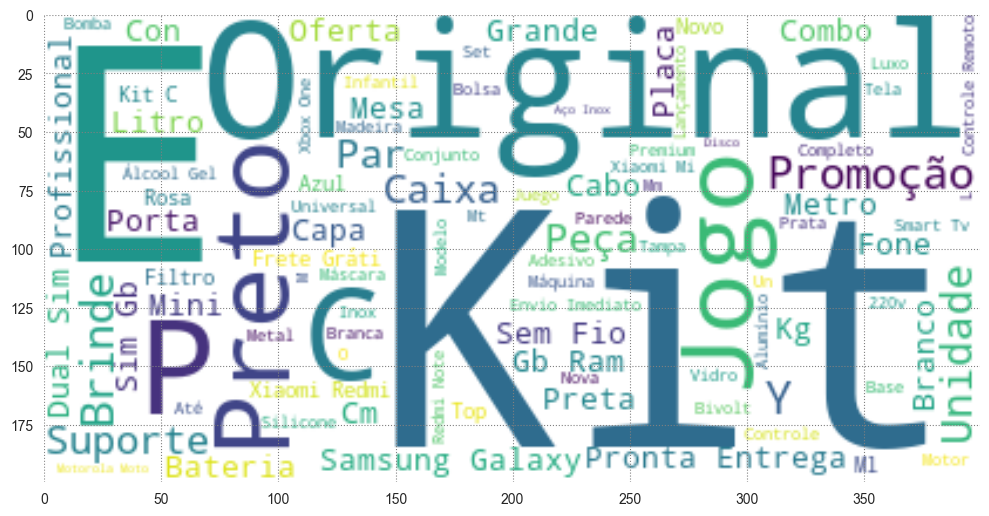

In [17]:
# lista de stopword
stopwords = set(STOPWORDS)
stopwords.update(["da", "meu", "em", "você", "de", "ao", "os", "br", "para"])

# gerar uma wordcloud
wordcloud = WordCloud(stopwords=stopwords,
                      background_color="white").generate(all_produto)

# mostrar a imagem final
fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(wordcloud, interpolation='bilinear')

plt.tight_layout()

Vejamos agora em relação à variável `categoria_produto`

In [18]:
df.categoria_produto.value_counts()

cat_43b9c10    2331
cat_d69bed9    1799
cat_604df77    1784
cat_6c4cfdc    1449
cat_4249bd8    1191
               ... 
cat_0d1c81b       1
cat_4fc8b8b       1
cat_9ba475f       1
cat_75e1eaf       1
cat_45b507c       1
Name: categoria_produto, Length: 8324, dtype: int64

In [19]:
len(df.categoria_produto.unique())

8324

Há mais de 8 mil categorias diferentes para cada produto. Uma ressalva importante é que poderiamos agrupar essas subcategorias em categorias maiores, diminuindo assim a cardinalidade (ex: vestuário, produtos eletrônicos, etc). Essa informação não está disponível no dataset, mas caso haja, poderia ser extraída de outras bases. Caso não haja em outras bases, poderia ser criado um widget para que o vendedor pudesse classificar o produto de forma mais macro e, se ainda assim isso não fosse possível, poderíamos criar um modelo de NLP e classificação que fosse capaz de entender as possíveis classes macro do produto, ou ainda um modelo não supervisionado de clusterização com informações que discriminem o produto (preço, perfil de cliente que efetua compra, etc). 



Vejamos em relação à variável `entrega_doc_1`

In [20]:
df.entrega_doc_1.value_counts()

1    135353
0     14647
Name: entrega_doc_1, dtype: int64

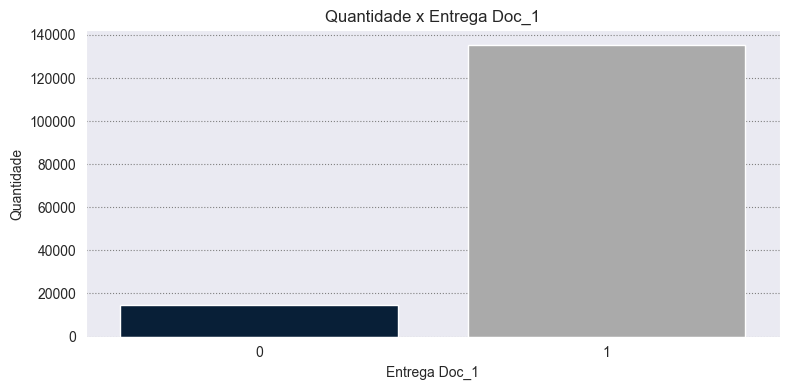

In [21]:
fig, ax = plt.subplots(figsize = (8, 4))
sns.set_style("darkgrid", {"grid.color": ".5", "grid.linestyle": ":"})
# Definindo a paleta de cores
colors = ["#001F3F", "#AAAAAA", "#334C66", "#7D99A8", "#D0D0D0"]
sns.set_palette(sns.color_palette(colors))
count = df.score_1.value_counts
sns.countplot(x='entrega_doc_1', data = df)
ax.set_xlabel("Entrega Doc_1")
ax.set_ylabel("Quantidade")
ax.set_title("Quantidade x Entrega Doc_1")
plt.tight_layout();

Há um desbalanceamento, onde a maioria dos usuários entregaram o documento 1.

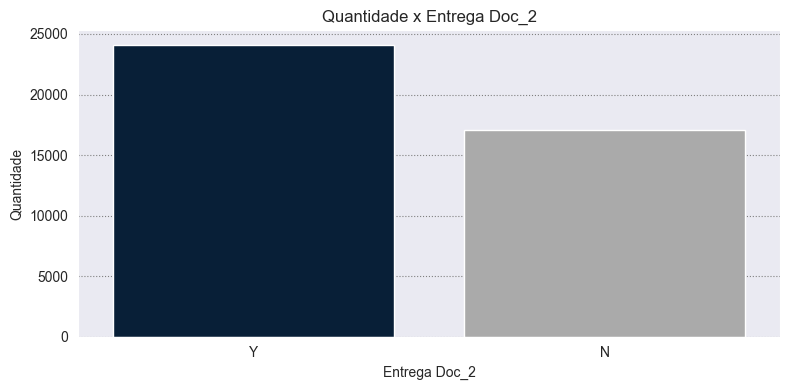

In [22]:
fig, ax = plt.subplots(figsize = (8, 4))
sns.set_style("darkgrid", {"grid.color": ".5", "grid.linestyle": ":"})
# Definindo a paleta de cores
colors = ["#001F3F", "#AAAAAA", "#334C66", "#7D99A8", "#D0D0D0"]
sns.set_palette(sns.color_palette(colors))
count = df.score_1.value_counts
sns.countplot(x='entrega_doc_2', data = df)
ax.set_xlabel("Entrega Doc_2")
ax.set_ylabel("Quantidade")
ax.set_title("Quantidade x Entrega Doc_2")
plt.tight_layout();

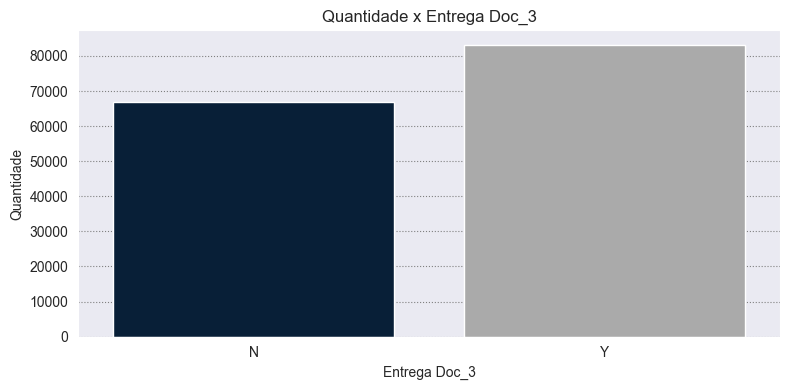

In [23]:
fig, ax = plt.subplots(figsize = (8, 4))
sns.set_style("darkgrid", {"grid.color": ".5", "grid.linestyle": ":"})
# Definindo a paleta de cores
colors = ["#001F3F", "#AAAAAA", "#334C66", "#7D99A8", "#D0D0D0"]
sns.set_palette(sns.color_palette(colors))
count = df.score_1.value_counts
sns.countplot(x='entrega_doc_3', data = df)
ax.set_xlabel("Entrega Doc_3")
ax.set_ylabel("Quantidade")
ax.set_title("Quantidade x Entrega Doc_3")
plt.tight_layout();

Por fim, a maioria dos usuários realizaram a entrega do documento 3.

Vejamos agora o balanceamento da **variável alvo** `fraude`.

In [24]:
# Quantidade de dados distribuidos pela variável alvo
df.fraude.value_counts()

0    142500
1      7500
Name: fraude, dtype: int64

In [25]:
# Quantidade de dados distribuidos pela variável alvo
round(df.fraude.value_counts()/df.shape[0],2)

0    0.95
1    0.05
Name: fraude, dtype: float64

Pode-se perceber que o dataset é altamente **desbalanceado**, contendo 95% das transações não fraudulentas e apenas 5% fraudulentas.

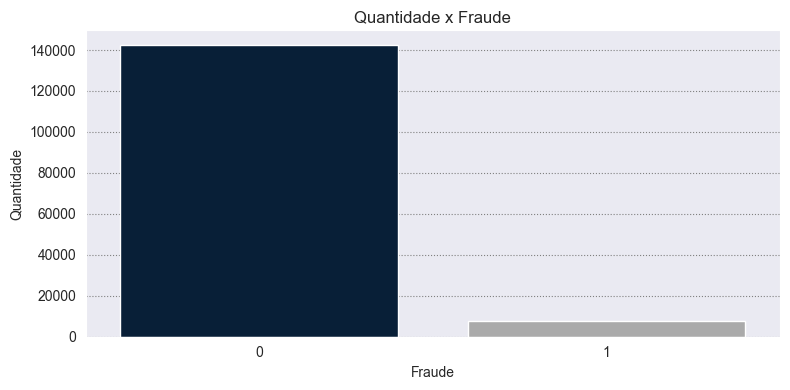

In [26]:
fig, ax = plt.subplots(figsize = (8, 4))
sns.set_style("darkgrid", {"grid.color": ".5", "grid.linestyle": ":"})
# Definindo a paleta de cores
colors = ["#001F3F", "#AAAAAA", "#334C66", "#7D99A8", "#D0D0D0"]
sns.set_palette(sns.color_palette(colors))
count = df.fraude.value_counts
sns.countplot(x='fraude', data = df)
ax.set_xlabel("Fraude")
ax.set_ylabel("Quantidade")
ax.set_title("Quantidade x Fraude")
plt.tight_layout();

In [27]:
df.describe()

,score_1,score_2,score_3,score_4,score_5,score_6,score_7,score_8,score_9,score_10,entrega_doc_1,valor_compra,score_fraude_modelo,fraude
count,150000.000000,137016.000000,1.370160e+05,149635.000000,150000.000000,149989.000000,150000.000000,150000.000000,149989.000000,149635.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,3.705407,0.728115,2.604451e+05,21.677669,0.220641,51.169352,14.193513,0.497532,2305.409403,299.969579,0.902353,43.523134,48.066240,0.050000
std,0.753206,0.132943,8.464361e+05,20.062146,2.434995,709.472904,14.161216,0.288348,1712.379601,321.075806,0.296837,91.557888,28.995122,0.217946
min,1.000000,0.000000,1.600000e-01,0.000000,0.000000,-5.000000,0.000000,0.000004,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000
25%,4.000000,0.678400,9.679915e+03,2.000000,0.000000,1.000000,3.000000,0.246819,910.000000,42.000000,1.000000,9.380000,23.000000,0.000000
50%,4.000000,0.755500,4.371165e+04,14.000000,0.104875,8.000000,9.000000,0.495990,1937.000000,193.000000,1.000000,20.610000,48.000000,0.000000
75%,4.000000,0.806500,1.454436e+05,50.000000,0.282938,33.000000,21.000000,0.746508,3445.000000,459.000000,1.000000,40.692500,73.000000,0.000000
max,4.000000,1.000000,1.387874e+07,50.000000,833.333333,145274.000000,58.000000,0.999995,7544.000000,2225.000000,1.000000,3696.350000,100.000000,1.000000


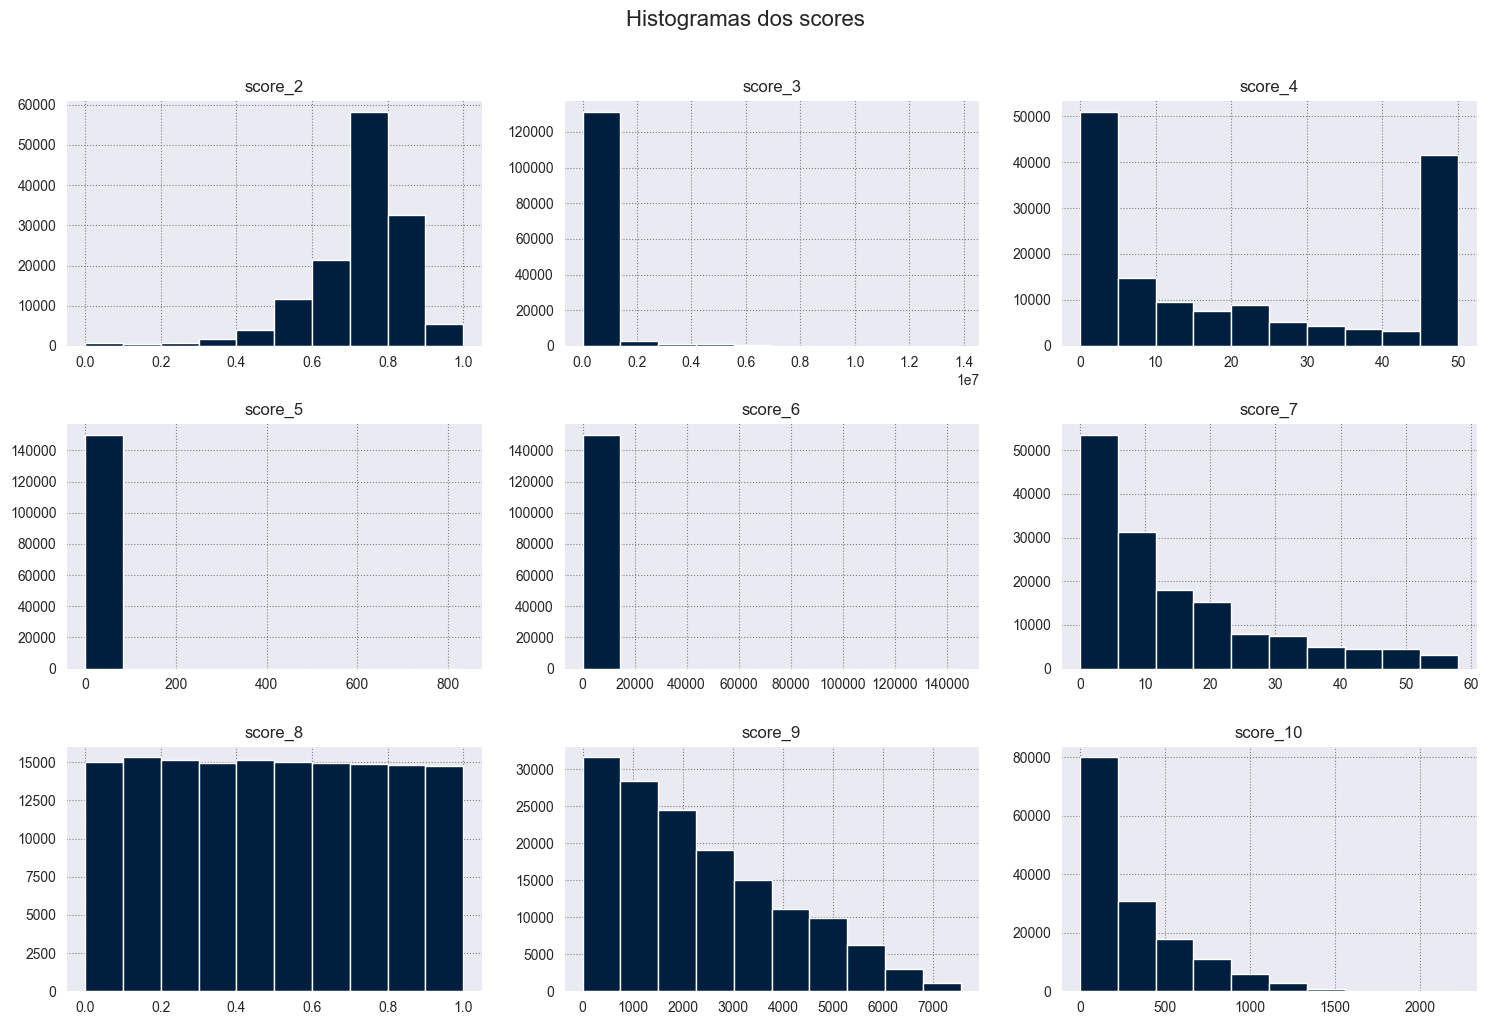

In [28]:
# Gera os histogramas
axarr = df[['score_2', 'score_3', 'score_4', 'score_5', 'score_6', 'score_7', 'score_8', 'score_9', 'score_10']].hist(figsize=(15, 10))

# Adiciona um título geral para a figura
plt.gcf().suptitle("Histogramas dos scores", fontsize=16, y=1.02)

plt.tight_layout()
plt.show()


Pode-se perceber que:
* `score_2` obtem uma assimetria à esquerda, ou seja, mais pessoas possuem uma pontuação alta.
* `score_7`, `score_9`, `score_10` possuem assimetria à direita, mais pessoas possuem uma pontuação mais baixa.
* `score_8` é uniforme.
* `score_4` possui dois picos no início e final.
* Os demais scores não estão discriminando bem e possuem grande amplitude.

In [29]:
print(f"Aplitude Score 3: {df.score_3.max() - df.score_3.min()}")
print(f"Aplitude Score 5: {df.score_5.max() - df.score_5.min()}")
print(f"Aplitude Score 6: {df.score_6.max() - df.score_6.min()}")

Aplitude Score 3: 13878743.55
Aplitude Score 5: 833.333333333333
Aplitude Score 6: 145279.0


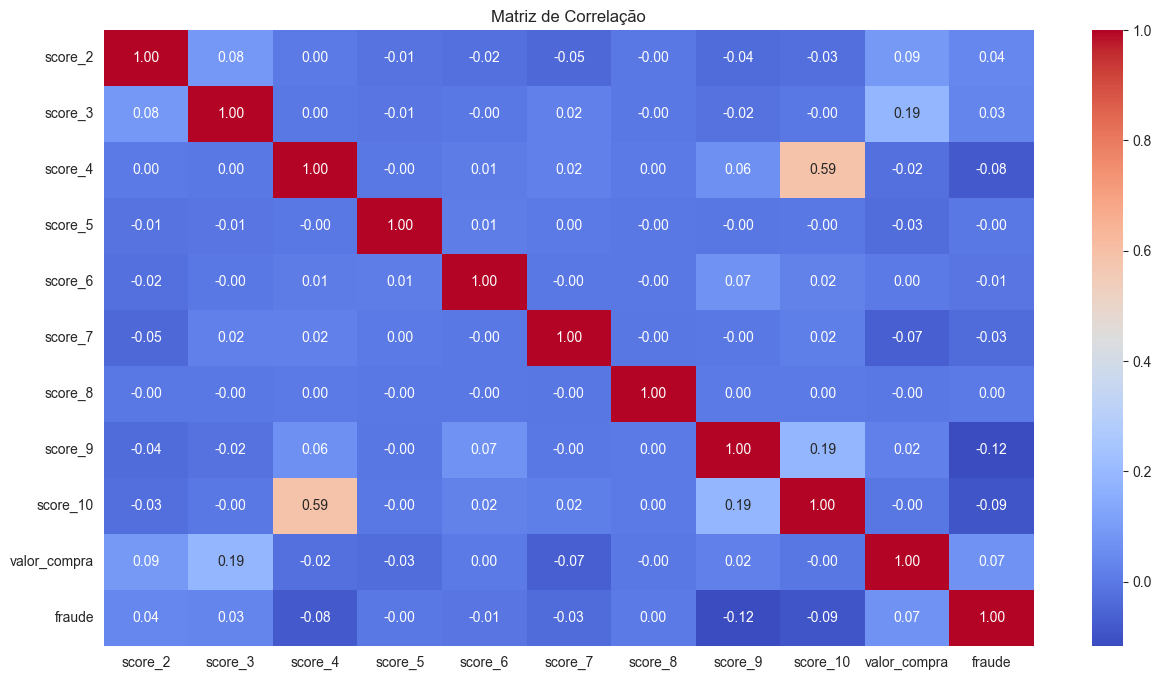

In [30]:
corr = df[['score_2', 'score_3', 'score_4', 'score_5', 'score_6', 'score_7', 'score_8', 'score_9', 'score_10', 'valor_compra', 'fraude']].corr()
plt.figure(figsize = (15, 8))
sns.heatmap(corr, annot = True, cmap = "coolwarm", fmt = ".2f")
plt.title("Matriz de Correlação")
plt.show()

Possuímos uma correlação positiva de 0.59 entre `score_10` e `score_4`, que é moderada.

Vejamos agora em relação ao valor da compra

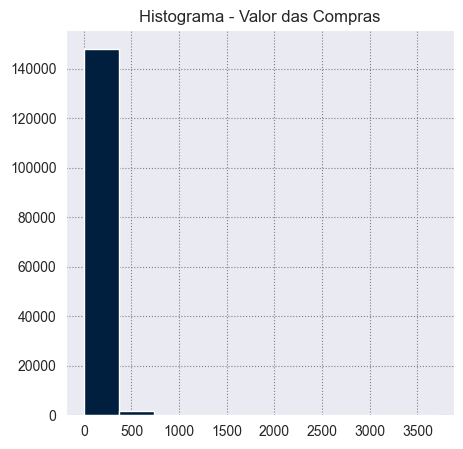

In [31]:
fig, ax = plt.subplots(figsize = (5, 5))
ax.set_title("Histograma - Valor das Compras")
df.valor_compra.hist(ax = ax);

In [32]:
df.valor_compra.describe()

count    150000.000000
mean         43.523134
std          91.557888
min           0.020000
25%           9.380000
50%          20.610000
75%          40.692500
max        3696.350000
Name: valor_compra, dtype: float64

Temos uma amplitude alta entre os valores da compra, e alto desvio padrão, a maioria das transações foram feitas com um valor de compra menor. Para facilitar a visualização, irei setar um limite de 450 no eixo x.

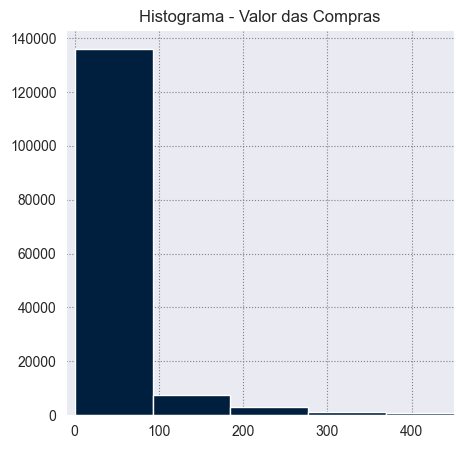

In [33]:
fig, ax = plt.subplots(figsize = (5, 5))
ax.set_title("Histograma - Valor das Compras")
ax.set_xlim(-10, 450)
df.valor_compra.hist(ax = ax, bins = 40);

### ANÁLISE EXPLORATÓRIA (EDA) BIVARIADA

Hipóteses:
1. Há alguma relação entre entrega dos documentos e fraude?
2. Há alguma relação entre score e fraude?
3. Há alguma relação entre país e fraude?
4. Há alguma relação entre fraude e tempo?


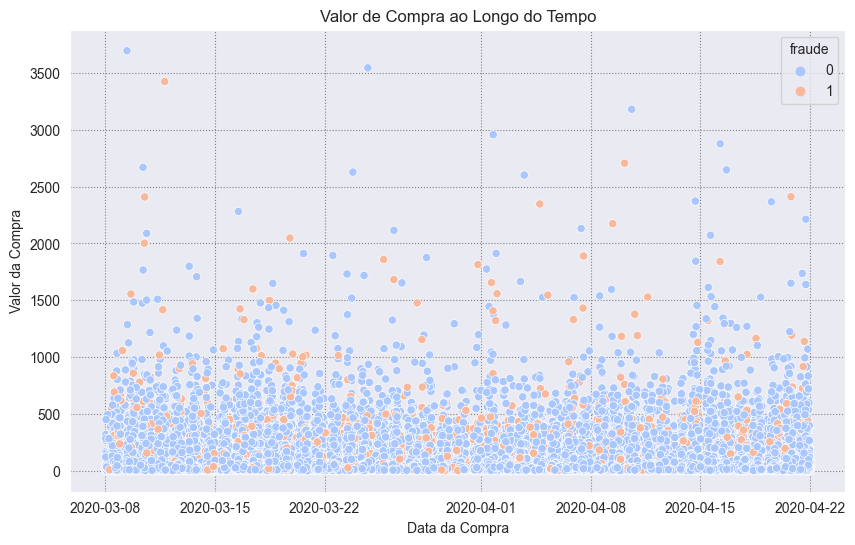

In [34]:
# Define o tamanho da figura
plt.figure(figsize=(10, 6))

# Plotando os dados
sns.scatterplot(x='data_compra', y='valor_compra', hue='fraude', data=df, palette="coolwarm")

# Configurando o título e os rótulos dos eixos
plt.title("Valor de Compra ao Longo do Tempo")
plt.xlabel("Data da Compra")
plt.ylabel("Valor da Compra")

# Mostra o gráfico
plt.show()


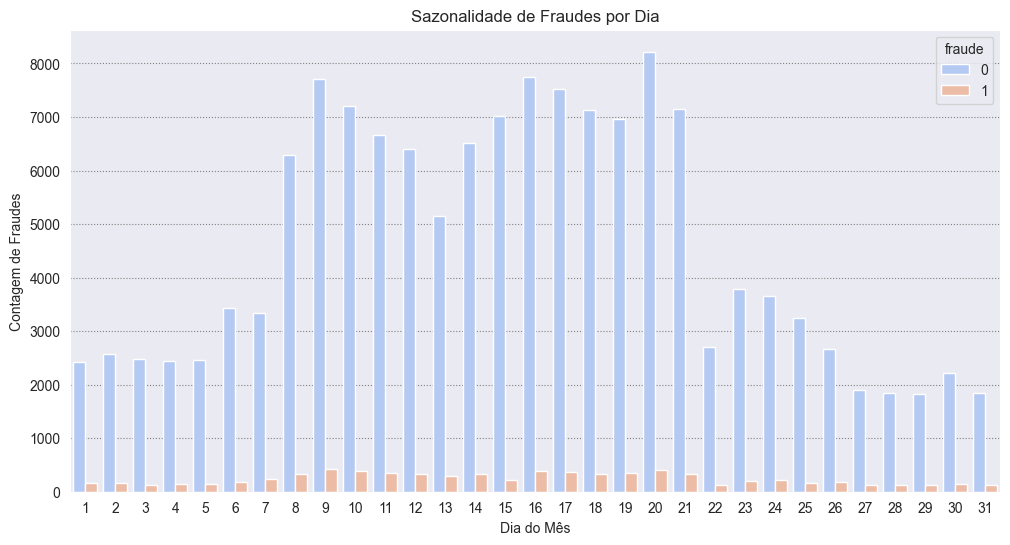

In [35]:
df_new = df.copy()

# Extrai o dia em uma coluna separada
df_new['dia'] = df_new['data_compra'].dt.day


# Define o tamanho da figura
plt.figure(figsize=(12, 6))

# Plotando a contagem de fraudes por dia
sns.countplot(x='dia', hue='fraude', data=df_new, palette='coolwarm')

# Configurando o título e os rótulos dos eixos
plt.title("Sazonalidade de Fraudes por Dia")
plt.xlabel("Dia do Mês")
plt.ylabel("Contagem de Fraudes")

# Mostra o gráfico
plt.show()

In [36]:
# Criar uma tabela de contingência
contingency_table = pd.crosstab(df_new["dia"], df_new["fraude"])

# Realizar o teste do qui-quadrado
chi2, p, _, expected = chi2_contingency(contingency_table)

print("Valor de chi2:", chi2)
print("Valor p:", p)

if p < 0.05:
    print("Rejeitamos a hipótese nula. Há uma relação significativa entre 'dia' e 'fraude'.")
else:
    print("Não rejeitamos a hipótese nula. 'dia' e 'fraude' parecem ser independentes.")
    

Valor de chi2: 176.07910490044085
Valor p: 1.3308511585064855e-22
Rejeitamos a hipótese nula. Há uma relação significativa entre 'dia' e 'fraude'.


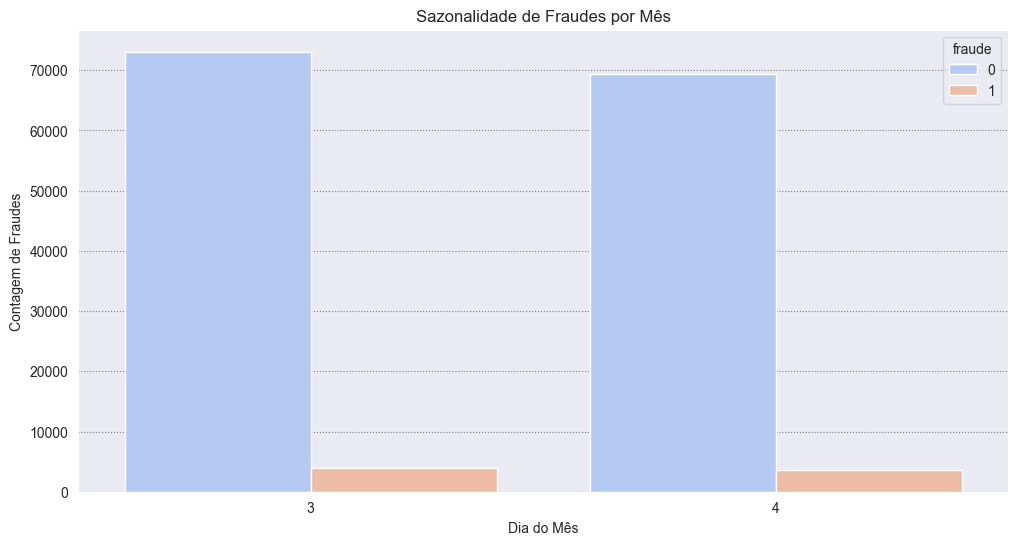

In [37]:
# Extrai o dia em uma coluna separada
df_new['mes'] = df_new['data_compra'].dt.month


# Define o tamanho da figura
plt.figure(figsize=(12, 6))

# Plotando a contagem de fraudes por dia
sns.countplot(x='mes', hue='fraude', data=df_new, palette='coolwarm')

# Configurando o título e os rótulos dos eixos
plt.title("Sazonalidade de Fraudes por Mês")
plt.xlabel("Dia do Mês")
plt.ylabel("Contagem de Fraudes")

# Mostra o gráfico
plt.show()

In [38]:
# Criar uma tabela de contingência
contingency_table = pd.crosstab(df_new["mes"], df_new["fraude"])

# Realizar o teste do qui-quadrado
chi2, p, _, expected = chi2_contingency(contingency_table)

print("Valor de chi2:", chi2)
print("Valor p:", p)

if p < 0.05:
    print("Rejeitamos a hipótese nula. Há uma relação significativa entre 'mes' e 'fraude'.")
else:
    print("Não rejeitamos a hipótese nula. 'mes' e 'fraude' parecem ser independentes.")
    

Valor de chi2: 0.45471226672131904
Valor p: 0.5001056271366706
Não rejeitamos a hipótese nula. 'mes' e 'fraude' parecem ser independentes.


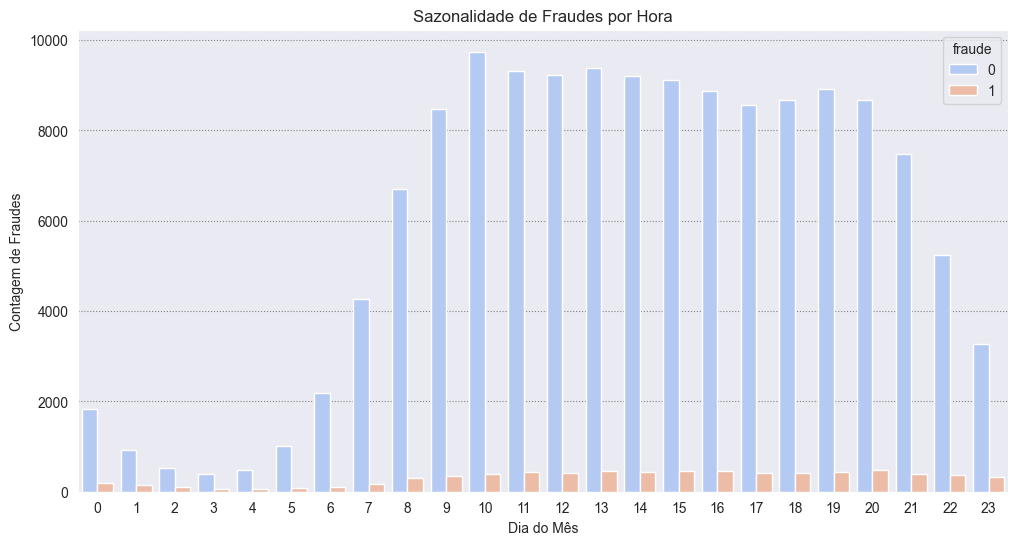

In [39]:
# Extrai o dia em uma coluna separada
df_new['hora'] = df_new['data_compra'].dt.hour

# Define o tamanho da figura
plt.figure(figsize=(12, 6))

# Plotando a contagem de fraudes por dia
sns.countplot(x='hora', hue='fraude', data=df_new, palette='coolwarm')

# Configurando o título e os rótulos dos eixos
plt.title("Sazonalidade de Fraudes por Hora")
plt.xlabel("Dia do Mês")
plt.ylabel("Contagem de Fraudes")

# Mostra o gráfico
plt.show()

In [40]:
from scipy.stats import chi2_contingency

# Criar uma tabela de contingência
contingency_table = pd.crosstab(df_new["hora"], df_new["fraude"])

# Realizar o teste do qui-quadrado
chi2, p, _, expected = chi2_contingency(contingency_table)

print("Valor de chi2:", chi2)
print("Valor p:", p)

if p < 0.05:
    print("Rejeitamos a hipótese nula. Há uma relação significativa entre 'hora' e 'fraude'.")
else:
    print("Não rejeitamos a hipótese nula. 'hora' e 'fraude' parecem ser independentes.")
    

Valor de chi2: 841.6593861727897
Valor p: 5.3030288311866235e-163
Rejeitamos a hipótese nula. Há uma relação significativa entre 'hora' e 'fraude'.


Apesar de rejeitarmos a hipótese nula para dia e hora, por não fazermos um modelo tipo time series, não faz sentido colocá-la como feature. Essa coluna, entretanto, poderia ser usada para verificar a performance do modelo em relação ao tempo, uma vez que os fraudadores desenvolvem técnicas diferentes ao longo do tempo, além de poder haver shift de população - o que pode degradar nosso modelo com o tempo. Contudo, no subconjunto fornecido temos apenas 2 meses de dados e, por isso, não será possível verificar tais comportamentos em tão pouco tempo. Dessa forma, a coluna será removida do modelo.

Faremos abaixo testes de hipóteses para verificar se há uma relação significativa entre `score_1` e `fraude`, bem como as entregas dos documentos, o país e o valor da compra.

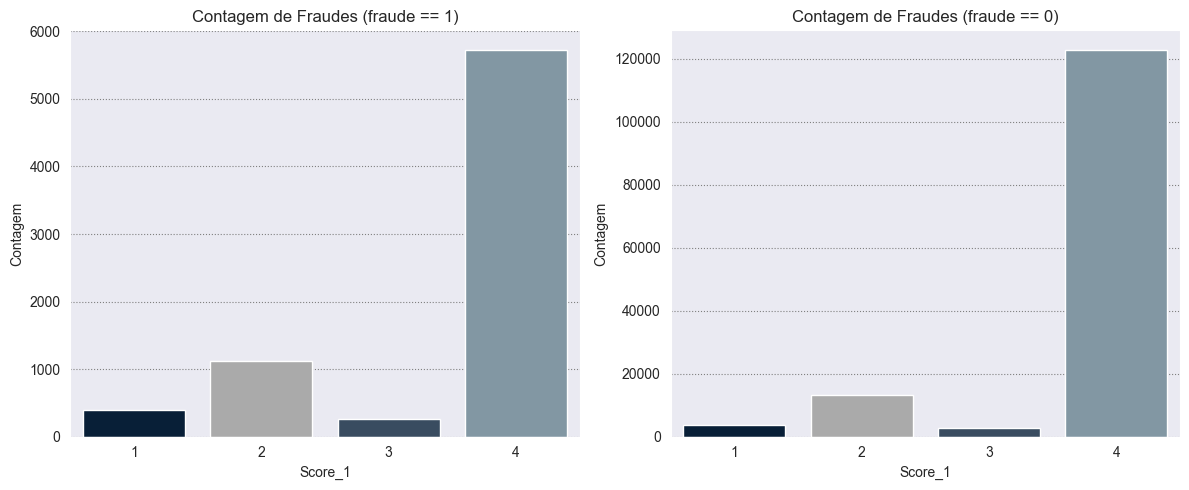

In [41]:
# Criar uma figura com dois eixos lado a lado
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico para fraude == 1
df_fraude_1 = df[df["fraude"] == 1]
sns.countplot(x="score_1", data=df_fraude_1, ax=axes[0])
axes[0].set_title("Contagem de Fraudes (fraude == 1)")
axes[0].set_xlabel("Score_1")
axes[0].set_ylabel("Contagem")

# Gráfico para fraude == 0
df_fraude_0 = df[df["fraude"] == 0]
sns.countplot(x="score_1", data=df_fraude_0, ax=axes[1])
axes[1].set_title("Contagem de Fraudes (fraude == 0)")
axes[1].set_xlabel("Score_1")
axes[1].set_ylabel("Contagem")

# Ajuste de espaço entre os gráficos
plt.tight_layout()
plt.show()

In [42]:
# Criar uma tabela de contingência
contingency_table = pd.crosstab(df["score_1"], df["fraude"])

# Realizar o teste do qui-quadrado
chi2, p, _, expected = chi2_contingency(contingency_table)

print("Valor de chi2:", chi2)
print("Valor p:", p)

if p < 0.05:
    print("Rejeitamos a hipótese nula. Há uma relação significativa entre 'score_1' e 'fraude'.")
else:
    print("Não rejeitamos a hipótese nula. 'score_1' e 'fraude' parecem ser independentes.")
    

Valor de chi2: 584.4465798546843
Valor p: 2.371872621590785e-126
Rejeitamos a hipótese nula. Há uma relação significativa entre 'score_1' e 'fraude'.


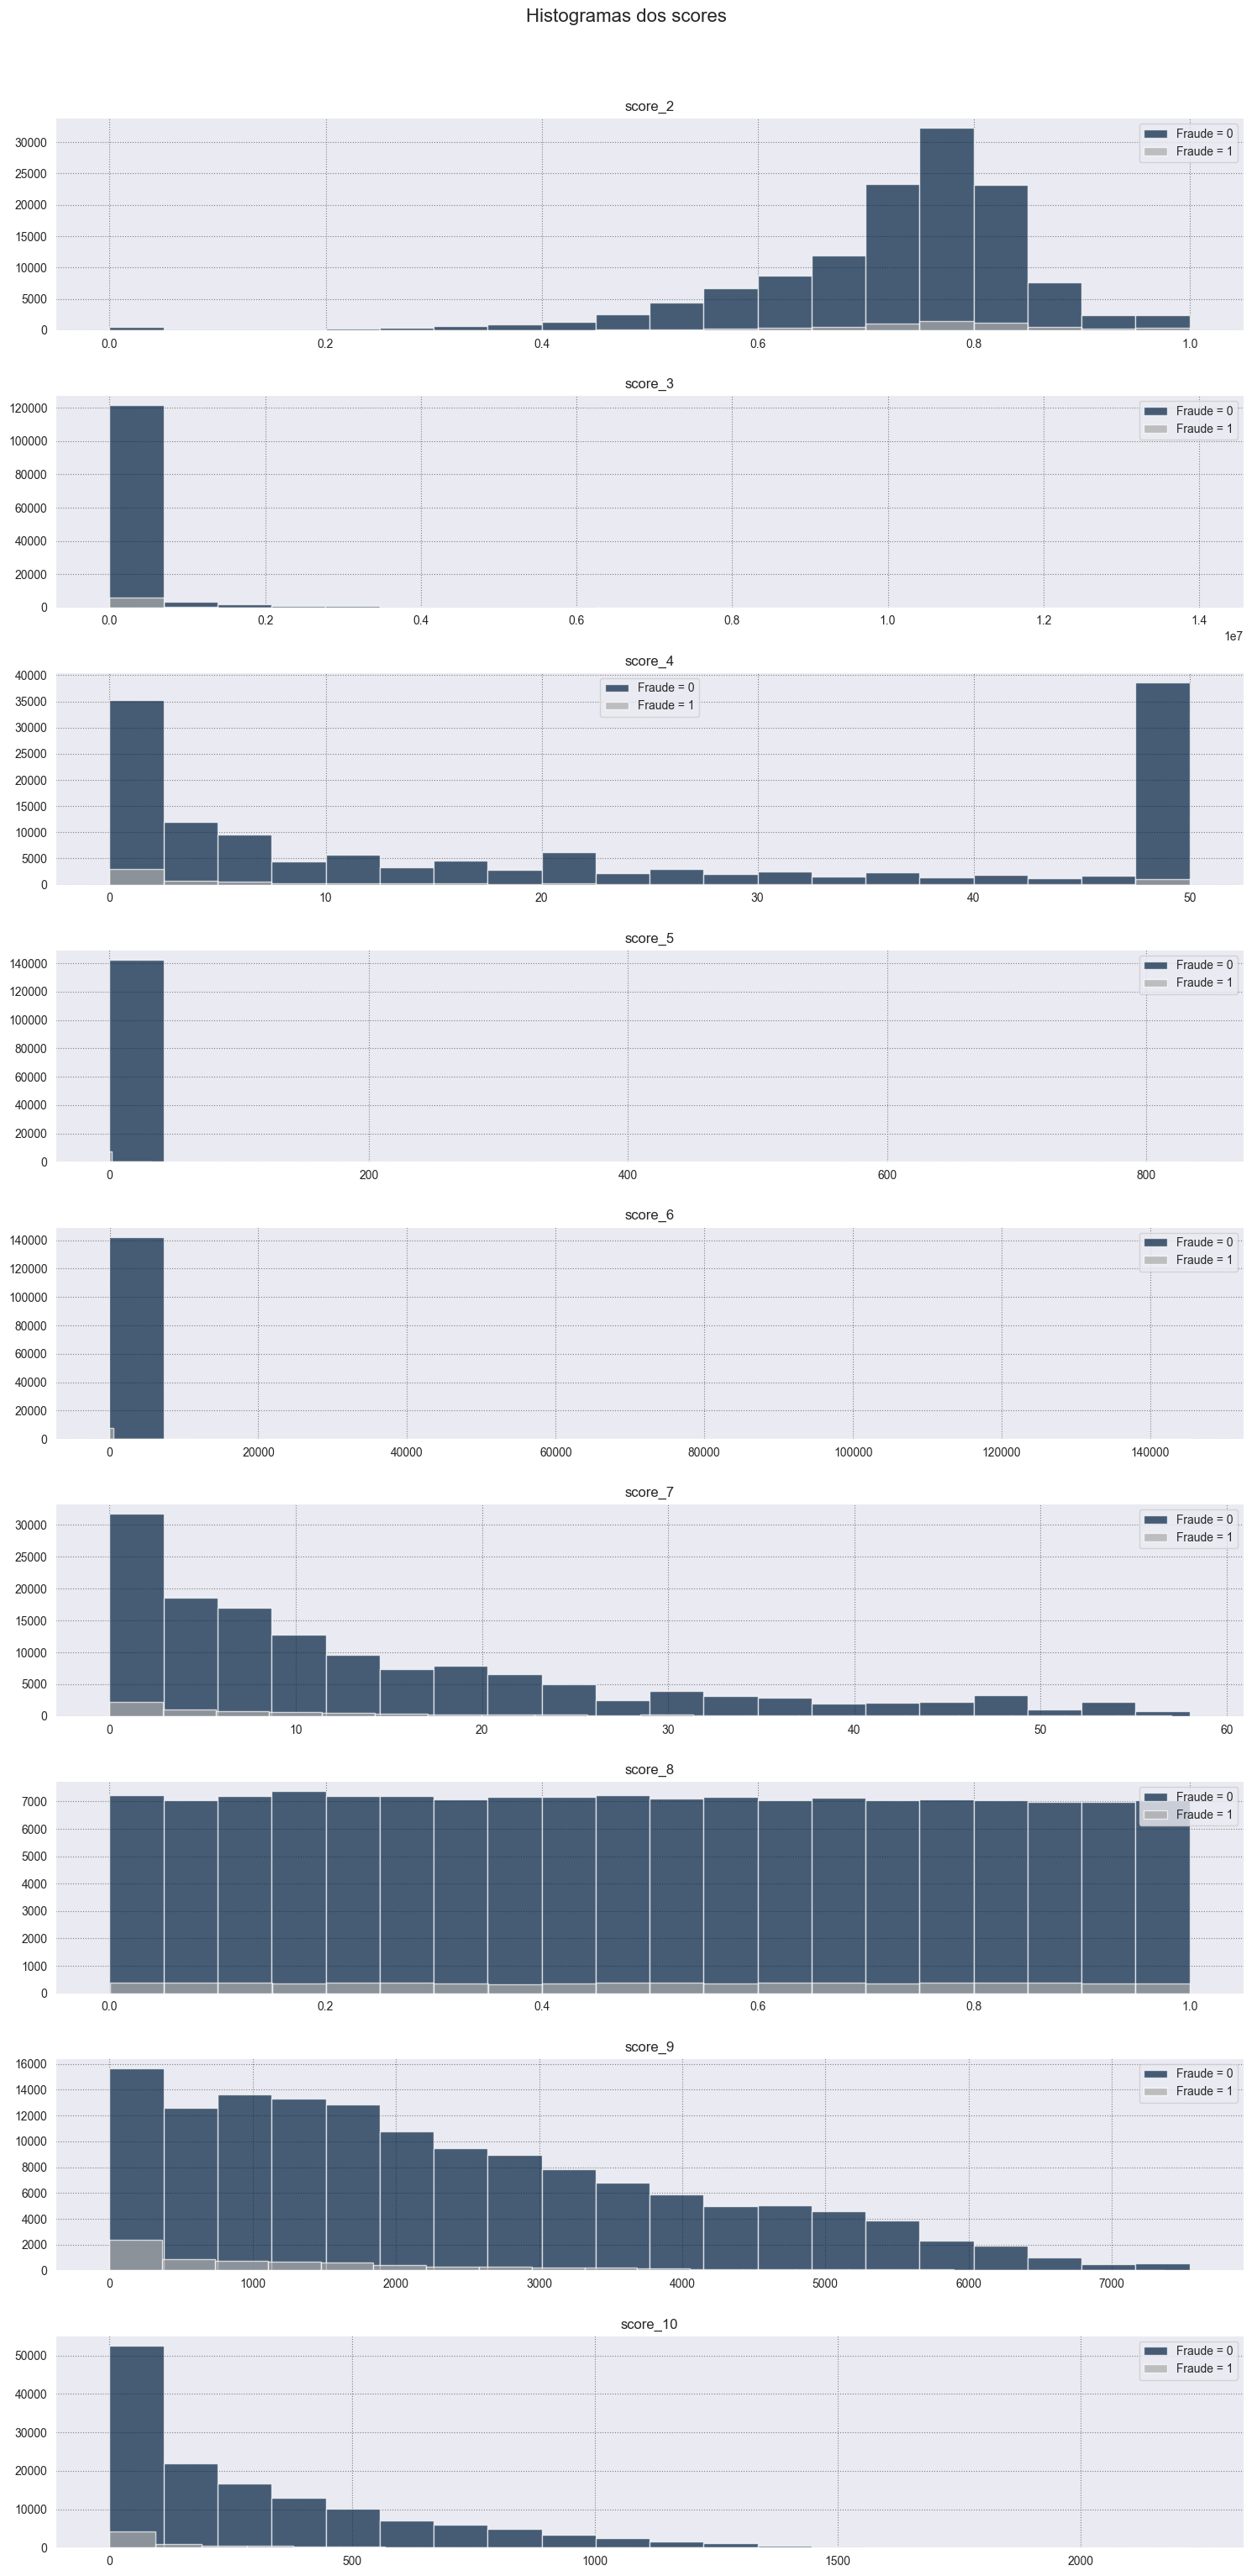

In [43]:
columns = ['score_2', 'score_3', 'score_4', 'score_5', 'score_6', 'score_7', 'score_8', 'score_9', 'score_10']

# Configurações de layout
fig, axarr = plt.subplots(len(columns), 1, figsize=(15, 30))

for i, col in enumerate(columns):
    df[df['fraude'] == 0][col].hist(ax=axarr[i], alpha=0.7, label='Fraude = 0', bins=20)
    df[df['fraude'] == 1][col].hist(ax=axarr[i], alpha=0.7, label='Fraude = 1', bins=20)
    axarr[i].set_title(col)
    axarr[i].legend()

# Adiciona um título geral para a figura
plt.suptitle("Histogramas dos scores", fontsize=16, y=1.02)

plt.tight_layout()
plt.show()


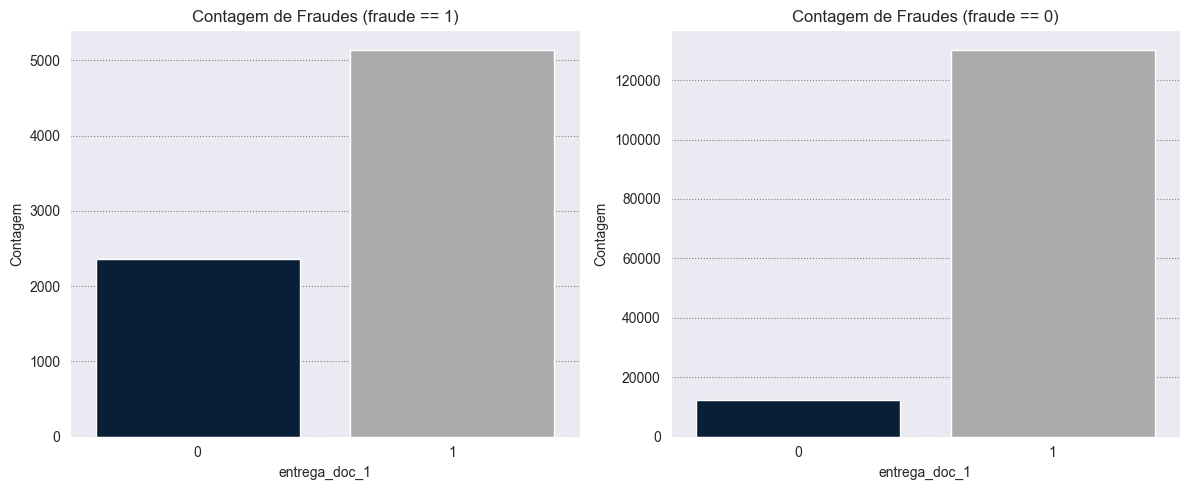

In [44]:
# Criar uma figura com dois eixos lado a lado
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico para fraude == 1
df_fraude_1 = df[df["fraude"] == 1]
sns.countplot(x="entrega_doc_1", data=df_fraude_1, ax=axes[0])
axes[0].set_title("Contagem de Fraudes (fraude == 1)")
axes[0].set_xlabel("entrega_doc_1")
axes[0].set_ylabel("Contagem")

# Gráfico para fraude == 0
df_fraude_0 = df[df["fraude"] == 0]
sns.countplot(x="entrega_doc_1", data=df_fraude_0, ax=axes[1])
axes[1].set_title("Contagem de Fraudes (fraude == 0)")
axes[1].set_xlabel("entrega_doc_1")
axes[1].set_ylabel("Contagem")

# Ajuste de espaço entre os gráficos
plt.tight_layout()
plt.show()

In [45]:
# Criar uma tabela de contingência
contingency_table = pd.crosstab(df["entrega_doc_1"], df["fraude"])

# Realizar o teste do qui-quadrado
chi2, p, _, _ = chi2_contingency(contingency_table)

print("Valor de chi2:", chi2)
print("Valor p:", p)

if p < 0.05:
    print("Rejeitamos a hipótese nula. Há uma relação significativa entre 'entrega_doc_1' e 'fraude'.")
else:
    print("Não rejeitamos a hipótese nula. 'entrega_doc_1' e 'fraude' parecem ser independentes.")

Valor de chi2: 4217.317158934374
Valor p: 0.0
Rejeitamos a hipótese nula. Há uma relação significativa entre 'entrega_doc_1' e 'fraude'.


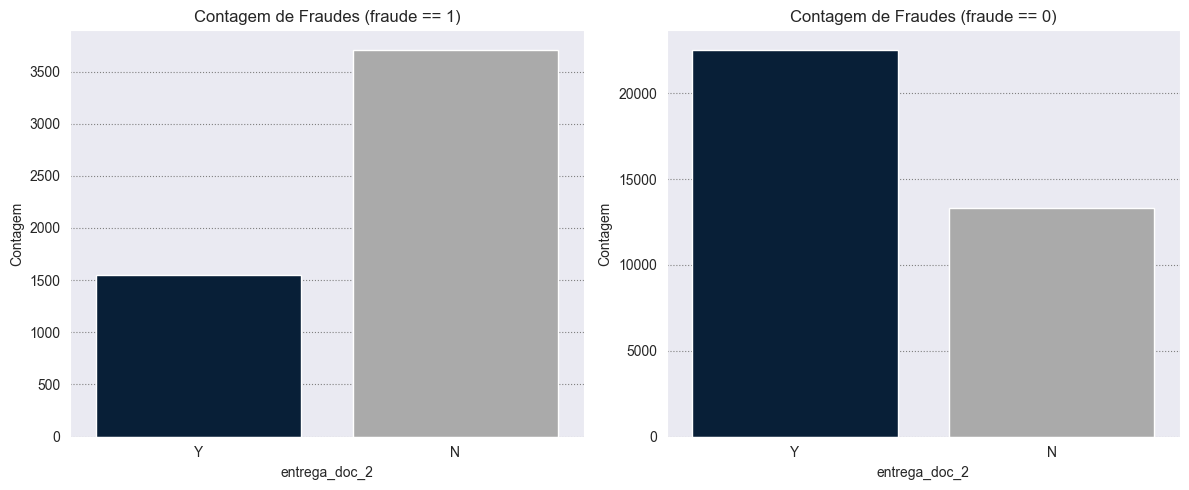

In [46]:
# Criar uma figura com dois eixos lado a lado
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico para fraude == 1
df_fraude_1 = df[df["fraude"] == 1]
sns.countplot(x="entrega_doc_2", data=df_fraude_1, ax=axes[0])
axes[0].set_title("Contagem de Fraudes (fraude == 1)")
axes[0].set_xlabel("entrega_doc_2")
axes[0].set_ylabel("Contagem")

# Gráfico para fraude == 0
df_fraude_0 = df[df["fraude"] == 0]
sns.countplot(x="entrega_doc_2", data=df_fraude_0, ax=axes[1])
axes[1].set_title("Contagem de Fraudes (fraude == 0)")
axes[1].set_xlabel("entrega_doc_2")
axes[1].set_ylabel("Contagem")

# Ajuste de espaço entre os gráficos
plt.tight_layout()
plt.show()

In [47]:
# Criar uma tabela de contingência
contingency_table = pd.crosstab(df["entrega_doc_2"], df["fraude"])

# Realizar o teste do qui-quadrado
chi2, p, _, _ = chi2_contingency(contingency_table)

print("Valor de chi2:", chi2)
print("Valor p:", p)

if p < 0.05:
    print("Rejeitamos a hipótese nula. Há uma relação significativa entre 'entrega_doc_2' e 'fraude'.")
else:
    print("Não rejeitamos a hipótese nula. 'entrega_doc_2' e 'fraude' parecem ser independentes.")

Valor de chi2: 2093.9742824255336
Valor p: 0.0
Rejeitamos a hipótese nula. Há uma relação significativa entre 'entrega_doc_2' e 'fraude'.


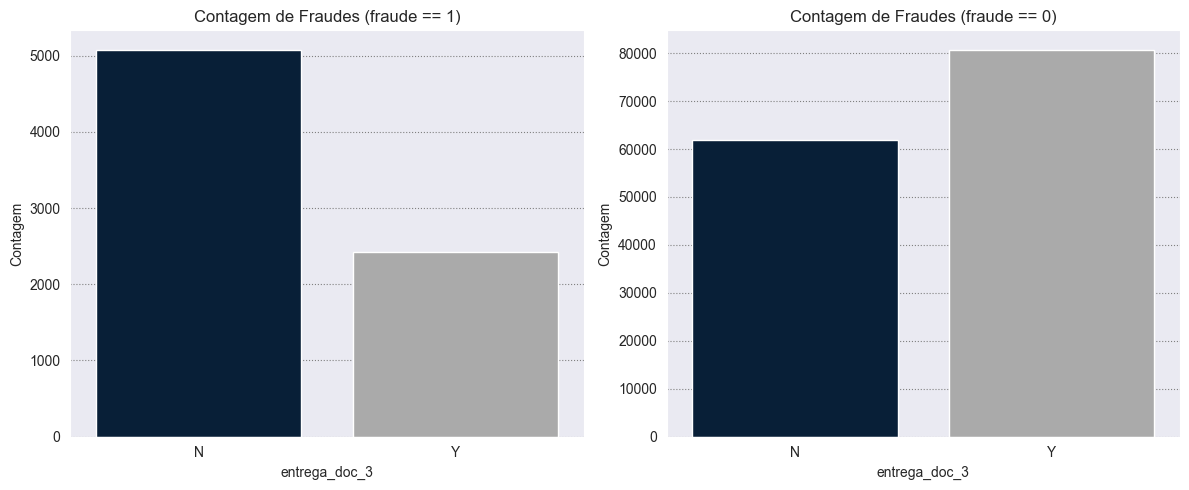

In [48]:
# Criar uma figura com dois eixos lado a lado
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico para fraude == 1
df_fraude_1 = df[df["fraude"] == 1]
sns.countplot(x="entrega_doc_3", data=df_fraude_1, ax=axes[0])
axes[0].set_title("Contagem de Fraudes (fraude == 1)")
axes[0].set_xlabel("entrega_doc_3")
axes[0].set_ylabel("Contagem")

# Gráfico para fraude == 0
df_fraude_0 = df[df["fraude"] == 0]
sns.countplot(x="entrega_doc_3", data=df_fraude_0, ax=axes[1])
axes[1].set_title("Contagem de Fraudes (fraude == 0)")
axes[1].set_xlabel("entrega_doc_3")
axes[1].set_ylabel("Contagem")

# Ajuste de espaço entre os gráficos
plt.tight_layout()
plt.show()

In [49]:
# Criar uma tabela de contingência
contingency_table = pd.crosstab(df["entrega_doc_3"], df["fraude"])

# Realizar o teste do qui-quadrado
chi2, p, _, _ = chi2_contingency(contingency_table)

print("Valor de chi2:", chi2)
print("Valor p:", p)

if p < 0.05:
    print("Rejeitamos a hipótese nula. Há uma relação significativa entre 'entrega_doc_3' e 'fraude'.")
else:
    print("Não rejeitamos a hipótese nula. 'entrega_doc_3' e 'fraude' parecem ser independentes.")

Valor de chi2: 1709.9413003678396
Valor p: 0.0
Rejeitamos a hipótese nula. Há uma relação significativa entre 'entrega_doc_3' e 'fraude'.


In [50]:
# Criar uma tabela de contingência
contingency_table = pd.crosstab(df["pais"], df["fraude"])

# Realizar o teste do qui-quadrado
chi2, p, _, _ = chi2_contingency(contingency_table)

print("Valor de chi2:", chi2)
print("Valor p:", p)

if p < 0.05:
    print("Rejeitamos a hipótese nula. Há uma relação significativa entre 'pais' e 'fraude'.")
else:
    print("Não rejeitamos a hipótese nula. 'pais' e 'fraude' parecem ser independentes.")

Valor de chi2: 435.0414968257157
Valor p: 7.757972296868586e-63
Rejeitamos a hipótese nula. Há uma relação significativa entre 'pais' e 'fraude'.


In [51]:
# Separar os valores com base na coluna fraude
group1 = df[df['fraude'] == 0]['valor_compra']
group2 = df[df['fraude'] == 1]['valor_compra']

# Realizar o teste
stat, p = mannwhitneyu(group1, group2)

print('Estatística:', stat)
print('Valor p:', p)

if p < 0.05:
    print("Há uma diferença estatisticamente significativa nas distribuições entre os grupos.")
else:
    print("Não há uma diferença estatisticamente significativa nas distribuições entre os grupos.")


Estatística: 463387165.0
Valor p: 5.049078387837292e-84
Há uma diferença estatisticamente significativa nas distribuições entre os grupos.


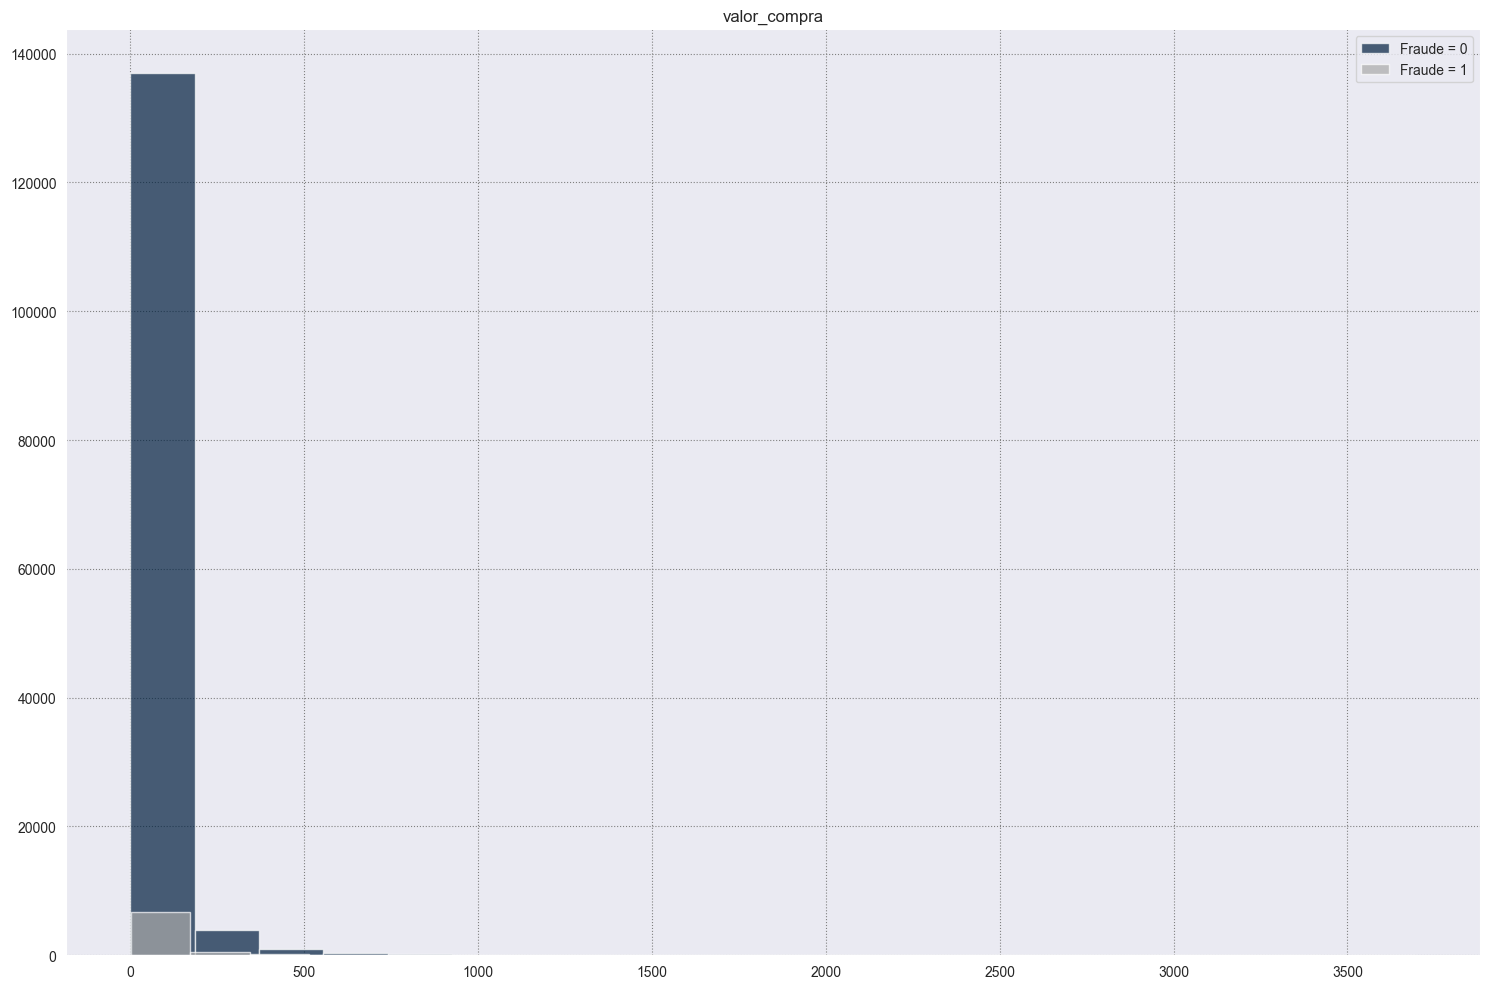

In [52]:
columns = ['valor_compra']

# Configurações de layout
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

df[df['fraude'] == 0][columns].hist(ax=ax, alpha=0.7, label='Fraude = 0', bins=20)
df[df['fraude'] == 1][columns].hist(ax=ax, alpha=0.7, label='Fraude = 1', bins=20)
ax.legend()


plt.tight_layout()
plt.show()


### Divisão do Conjunto de Dados
Antes de realizar o pré-processamento dos dados, irei separar o conjunto de teste que validará a eficácia do modelo. É importante que o mesmo seja capaz de generalizar para evitar problemas como o underfitting, que ocorre quando o modelo tem baixo desempenho tanto no treinamento quanto na validação, ou o overfitting, que ocorre quando o modelo se adapta demasiadamente ao treinamento e não consegue generalizar para novos dados. A separação antes da padronização ocorre para que os dados de teste não tenham contato com os de treino e validação, simulando uma situação real.

In [53]:
def split_df(df):
    df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
    return df_train, df_test

df_train, df_test = split_df(df)

X_train = df_train.drop('fraude', axis=1)
y_train = df_train.fraude

X_test = df_test.drop('fraude', axis=1)
y_test = df_test.fraude

### Modelo Baseline

Primeiramente, verificaremos a distribuição do modelo atual. É possível notar que o modelo está longe do ideal, pois há uma intersecção grande entre transações fraudulentas e reais na classificação. 

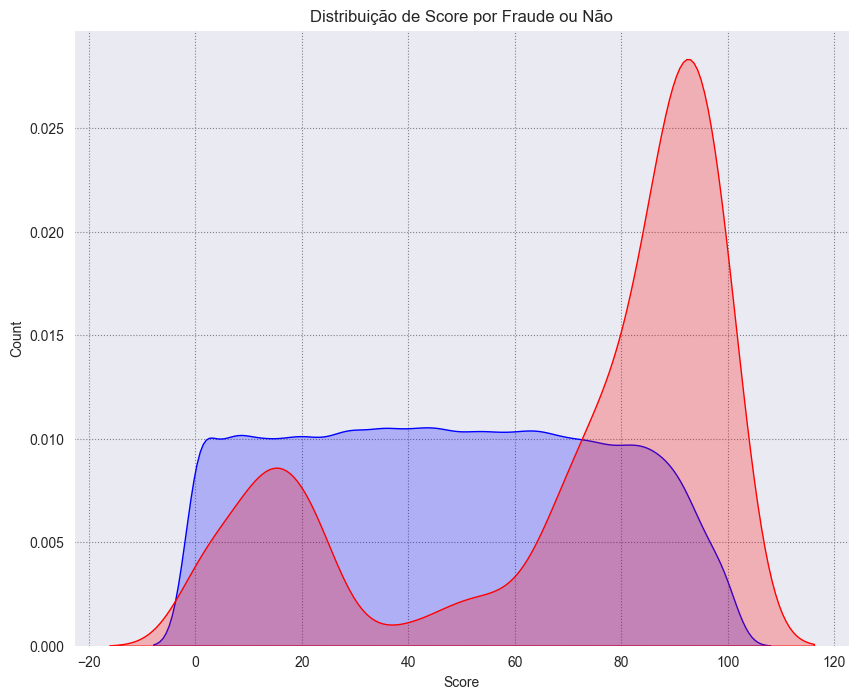

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.kdeplot(df.loc[lambda df: df.fraude == 0]['score_fraude_modelo'], ax=ax, color="b", fill = True)
sns.kdeplot(df.loc[lambda df: df.fraude == 1]['score_fraude_modelo'], ax=ax, color="r", fill = True)

plt.title("Distribuição de Score por Fraude ou Não")
plt.xlabel("Score")
plt.ylabel("Count");

Verificaremos agora outras métricas, como AUC, matriz de confusão e afins.

In [55]:
fpr, tpr, thresholds = roc_curve(df['fraude'], df['score_fraude_modelo'])
auc = auc(fpr, tpr)
print("ROC AUC: ", auc)

ROC AUC:  0.726275487251462


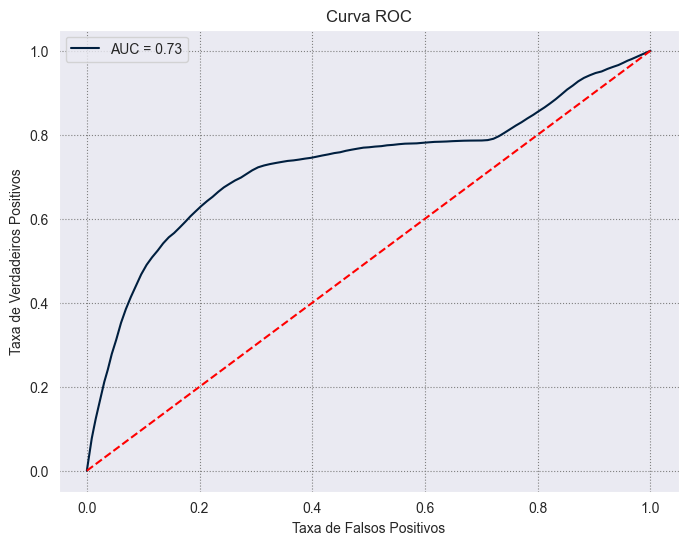

In [56]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

Por fim, iremos verificar qual o threshold que maximiza o lucro e plotar as demais métricas. Será assumido que o valor da compra está em uma única unidade de medida.

In [57]:
def profit_from_decision(decision_df, blocked_col, target_col, amount_col):
    """
    Calculates fraud losses, revenues, and profit based on the given decision dataframe.
    
    Parameters:
    - decision_df (pd.DataFrame): Dataframe containing decision data
    - blocked_col (str): Name of the column indicating if a transaction was blocked
    - target_col (str): Name of the column indicating if a transaction was a fraud
    - amount_col (str): Name of the column indicating the transaction amount
    
    Returns:
    pd.Series: Series containing summed values of fraud losses, revenues, and profit
    """
    
    # Fraud losses: when a transaction was not blocked but it was a fraud
    decision_df["fraud_losses"] = ((~decision_df[blocked_col]) & (decision_df[target_col])) * decision_df[amount_col]
    
    # Revenues: when a transaction was not blocked and it was not a fraud
    decision_df["revenues"] = ((~decision_df[blocked_col]) & (~decision_df[target_col])) * decision_df[amount_col] * 0.1
    
    # Profit: Revenues minus Fraud losses
    decision_df["profit"] = decision_df["revenues"] - decision_df["fraud_losses"]
    
    return decision_df[["fraud_losses", "revenues", "profit"]].sum()

In [58]:
target_col = "fraude"
prediction_col = "score_fraude_modelo"
amount_col = "valor_compra" 
blocked_col = "blocked"

possible_thresholds = np.arange(1, 100, 1)
all_decisions = []

for threshold in possible_thresholds: 
    all_decisions.append(profit_from_decision(df_test.assign(blocked=lambda df_test: df_test[prediction_col] >= threshold), blocked_col, 
                                              target_col, amount_col)
                         )
    

threshold_evaluation = pd.concat(all_decisions, axis=1, keys=[s for s in possible_thresholds]).T.rename_axis("threshold").reset_index()

threshold_evaluation

,threshold,fraud_losses,revenues,profit
0,1,1181.23,3242.109,2060.879
1,2,1890.99,3917.883,2026.893
2,3,1969.12,4829.258,2860.138
3,4,2288.36,5726.876,3438.516
4,5,2692.96,6743.685,4050.725
...,...,...,...,...
94,95,84125.99,111680.516,27554.526
95,96,87603.24,112932.551,25329.311
96,97,90925.22,113735.367,22810.147
97,98,94238.31,114322.705,20084.395


In [59]:
best_threshold = threshold_evaluation.loc[threshold_evaluation["profit"].idxmax()]["threshold"]
best_decision_anterior = threshold_evaluation.loc[lambda df: df["profit"].idxmax()]
best_decision_anterior.reset_index().rename(columns = {72: 'valor $'})

,index,valor $
0,threshold,73.000
1,fraud_losses,25353.320
2,revenues,80329.995
3,profit,54976.675


Com o modelo atual, há uma perda de 25 mil por fraudes, um ganho de 80 mil, e por fim, um lucro de 54 mil. Contudo, é importante destacar que esses dados são amostrais e não refletem o todo.

In [60]:
df_test['predicted'] = df_test[prediction_col] >= best_threshold
cm = confusion_matrix(df_test[target_col], df_test['predicted'])

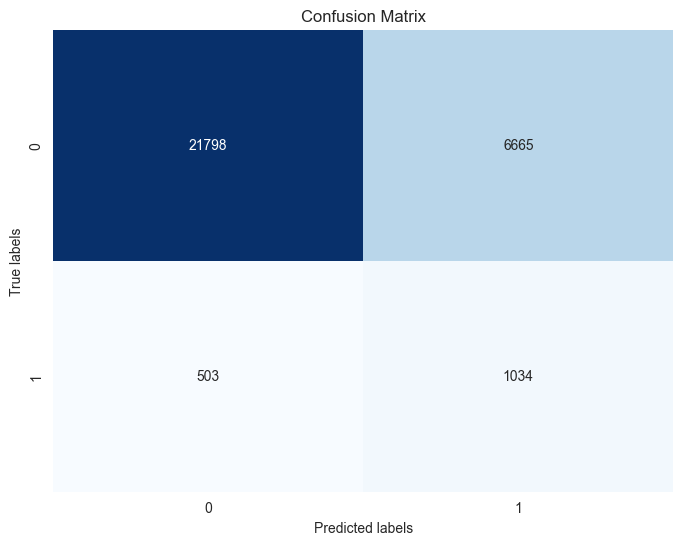

In [61]:
def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(cm)

In [62]:
print(f"Taxa de fraude = {round(503/22301,2)}")
print(f"Taxa de aprovação = {round(22301/30000,2)}")

Taxa de fraude = 0.02
Taxa de aprovação = 0.74


Como visto acima, nossa **taxa de fraude** é de **2%** e a **taxa de aprovação** de **74%**!

Veremos agora mais métricas do modelo como log loss, AUC, e afins.

In [63]:
# Converte as probabilidades em classificações binárias com base em um limiar (0.5 é comum)
y_pred_binary = df_test[prediction_col] >= best_threshold

# Calcula as métricas de desempenho
loss = log_loss(y_test, y_pred_binary)
roc_auc = roc_auc_score(y_test, df_test[prediction_col] >= best_threshold)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

# Imprime as métricas de desempenho
print(f'Log Loss: {loss:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'Precisão: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

Log Loss: 8.2526
ROC-AUC: 0.7193
Precisão: 0.13
Recall: 0.67
F1-score: 0.22


### Pré-processamento

#### Considerações
* A coluna `valor_compra` refere-se ao valor da compra e está em uma única unidade (ex: Dólar)
* Não há custo extra de fraude além do mencionado
* Nenhuma das colunas inseridas no modelo poderão causar data leakage - ou seja, todas esses dados são calculados/recebidos antes que o evento "Fraude" ocorra.

#### Para o pré-processamento, eu optei por:

* Excluir a coluna `score_fraude_modelo`, que é o modelo baseline e não deve ser utilizada.
* Excluir a coluna `data_compra`, a fim de não degradar o modelo com o tempo.
* Excluir a coluna `produto`, devido a alta cardinalidade (mais de 8 mil categorias), bem como `categoria_produto`.
* Limitar o `país` entre BR, AR (que compõe mais de 90% de toda a distribuição) e outros.
* Preencher os valores nulos de score com a mediana, pois não seguem uma distribuição normal.
* Criar uma feature `is_null` e indicando quais valores de `entrega_doc_2` são nulos. 
* Considerar os nulos de `entrega_doc_2` como 0, ou seja, não entregou.
* Fazer target encoder nas varíaveis categóricas

In [64]:
class ColumnDropper(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(columns=['data_compra', 'produto', 'categoria_produto', 'score_fraude_modelo'], axis = 1)
    
class DataProcessor(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        
        # Cria a coluna 'is_missing' com 1 para valores ausentes e 0 para valores não ausentes
        X_copy['is_missing'] = X_copy['entrega_doc_2'].isnull().astype(int)
        
        # Preenche os valores nulos com 0
        X_copy['entrega_doc_2'] = X_copy['entrega_doc_2'].fillna(0)

        # Processamento de colunas específicas
        X_copy['pais'] = X_copy['pais'].apply(lambda x: x if x in ['BR', 'AR'] else 'Outros')
        X_copy['entrega_doc_3'] = X_copy['entrega_doc_3'].apply(lambda x: 1 if x == 'Y' else 0)
        
        return X_copy

class ScoreImputer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        cols = ['score_2', 'score_3', 'score_4', 'score_5', 'score_6', 'score_7', 'score_8', 'score_9', 'score_10']
        imputer = SimpleImputer(strategy = "median")
        for col in cols:
            X_copy[col] = imputer.fit_transform(X_copy[[col]])
        return X_copy
    
class FeatureEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.encoder = ce.TargetEncoder(cols=['score_1', 'pais', 'entrega_doc_1', 'entrega_doc_2', 'entrega_doc_3', 'is_missing'])
    
    def fit(self, X, y=None):
        if y is None:
            raise ValueError("y should not be None for TargetEncoding during fit")
        self.encoder.fit(X, y)
        return self
    
    def transform(self, X):
        return self.encoder.transform(X)

def pipeline(model):
    # Criando o pipeline
    pipe = Pipeline([
        ("dropper", ColumnDropper()),
        ("processor", DataProcessor()),
        ("imputer", ScoreImputer()),
        ("encoder", FeatureEncoder()),
        ('classifier', model)
    ])
    
    return pipe

### Treinamento dos Algoritmos de Machine Learning

#### Maximizando a acurácia balanceada

Balanced RF: 0.765759 (0.006177)
Light GBM: 0.766128 (0.008125)
XGBoost: 0.740371 (0.002635)
Decision Tree: 0.590531 (0.006543)
Bagged Balanced RF: 0.767138 (0.006486)


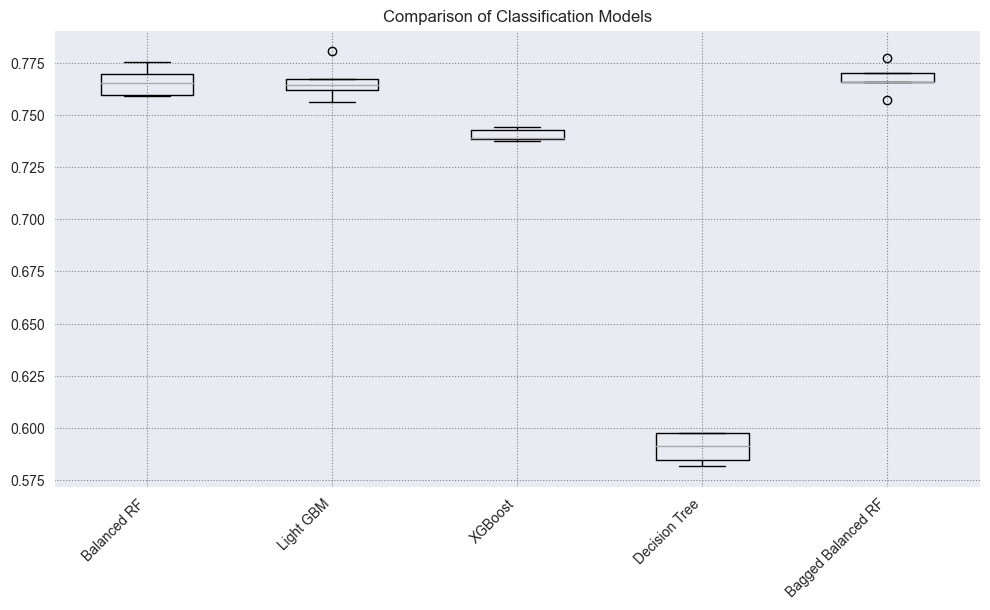

In [65]:
BRC = BalancedRandomForestClassifier(random_state=1234)
XGB = XGBClassifier(scale_pos_weight=19, random_state=1234)
LGB = LGBMClassifier(class_weight='balanced', random_state=1234)
DTC = DecisionTreeClassifier(class_weight='balanced', random_state=1234)
BaggedBRC = BaggingClassifier(base_estimator=BalancedRandomForestClassifier(random_state=1234), random_state=1234)

models = [BRC, LGB, XGB, DTC, BaggedBRC]

# Use shorter, more descriptive names for the models for better readability
model_names = ["Balanced RF", "Light GBM", "XGBoost", "Decision Tree", "Bagged Balanced RF"]

results = []

# Train models
for item in models:
    pipe = pipeline(item)
    kfold = KFold(n_splits=5, random_state=42, shuffle=True)
    cv_results = cross_val_score(pipe, X_train, y_train, cv=kfold, scoring='balanced_accuracy')
    results.append(cv_results)
    msg = "%s: %f (%f)" % (model_names[models.index(item)], cv_results.mean(), cv_results.std())
    print(msg)

# Plot comparison of models
fig, ax = plt.subplots(figsize=(10, 6))  # Increase the size for better clarity
ax.boxplot(results)
ax.set_xticklabels(model_names)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)  # Rotate and adjust fontsize of x-labels
plt.tight_layout()  # Adjust layout
plt.title('Comparison of Classification Models')
plt.show()

Dos modelos testados, o `Decision Tree` foi o que obteve o pior desempenho. O `Balanced RF` e o `Bagged Balanced RF` foram os que obtiveramm os melhores resultados, e o `XGBoost` obteve desempenho semelhante.
Apesar de não obter a maior métrica, optei por seguir com o `XGBoost` devido à quantidade de parâmetros que podemm ser personalizados em ajuste. Além disso, o XGBoost obteve o menor erro padrão, o que me dá indidícios que ele generalizará bem no conjunto de teste.

### Ajuste dos hiperparâmetros

Irei utilizar o Randomized Search CV para realizar o ajuste dos hiperparâmetros. O RandomizedSearchCV é uma abordagem para a otimização de hiperparâmetros que é diferente do tradicional método de busca em grid (GridSearchCV). Em vez de procurar por todas as combinações possíveis de hiperparâmetros (como o GridSearchCV faz), o RandomizedSearchCV seleciona um número fixo de combinações de hiperparâmetros aleatoriamente de um espaço de possibilidades. 

In [66]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment(experiment_name="Fraud")
mlflow.start_run(run_name="Pré-processamento 3")
mlflow.set_tag("description", "Treino/Teste XGBoost")
mlflow.autolog() 

XGB = XGBClassifier(scale_pos_weight=19, random_state=1234)
pipe = pipeline(XGB)

parameters = {
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__n_estimators': [50, 100, 250],
    'classifier__max_depth': [4, 6, -1],  # -1 means no constraint
    'classifier__subsample': [0.7, 0.9, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__min_child_weight': [1, 5, 10], 
    'classifier__gamma': [0, 0.5, 1],  # it's a regularization parameter in XGBoost
    'classifier__reg_alpha': [0, 0.5, 1],  # L1 regularization
    'classifier__reg_lambda': [0, 0.5, 1],  # L2 regularization
}


random_search = RandomizedSearchCV(pipe, parameters, cv=4, n_jobs=4, scoring="roc_auc")
random_search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % random_search.best_score_)
print(random_search.best_params_)
mlflow.log_metric("training_roc_auc", random_search.best_score_)


2023/10/20 09:43:45 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/10/20 09:43:45 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2023/10/20 09:43:46 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/10/20 09:43:49 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2023/10/20 09:43:49 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=[('dropper', ColumnDropper()), ('processor', DataProcessor()),
                ('imputer', ScoreImputer()), ('encoder', FeatureEncoder()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categ...`
2023/10/2

Best parameter (CV score=0.844):
{'classifier__subsample': 1.0, 'classifier__reg_lambda': 0, 'classifier__reg_alpha': 0, 'classifier__n_estimators': 50, 'classifier__min_child_weight': 1, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.2, 'classifier__gamma': 1, 'classifier__colsample_bytree': 1.0}


### Avaliação do Modelo Utilizando os Dados de Teste
No começo do projeto, realizamos um split nos dados para que tivéssemos 2 conjuntos: Um de treino e um de teste. Agora que já exploramos, preparamos os dados e treinamos o modelo, é hora de descobrirmos o potencial do modelo com os dados de teste.

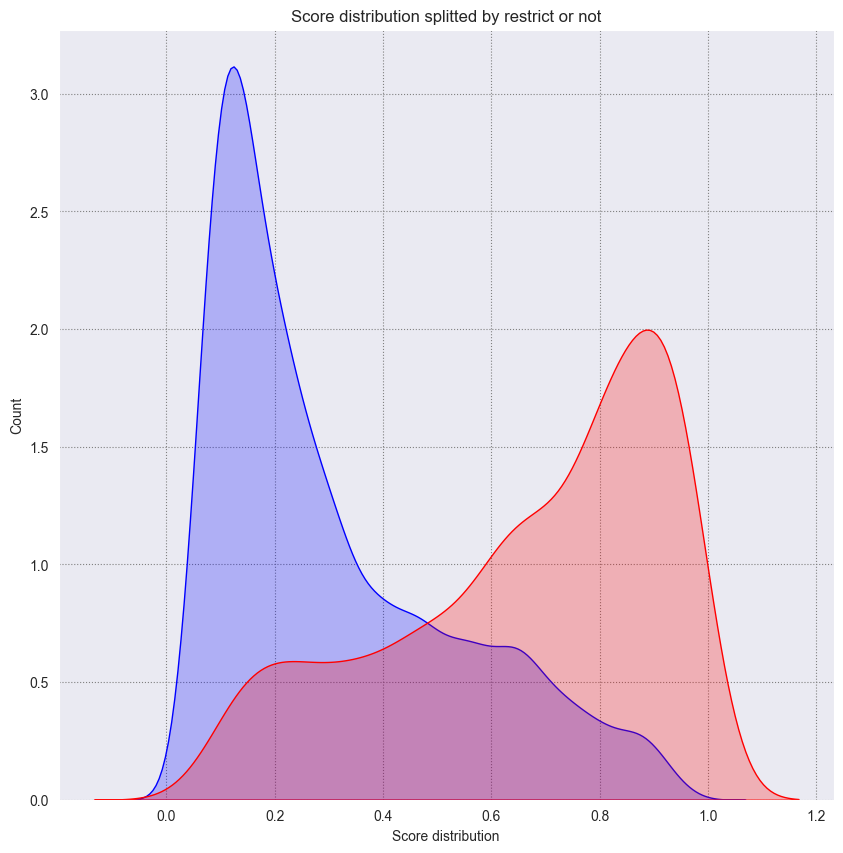

In [67]:
model = random_search.best_estimator_

y_test_pred = model.predict(X_test)
probs_test = model.predict_proba(X_test)

dataframe = df_test.copy()
dataframe['target_col'] = dataframe['fraude'] 
dataframe['prediction_col'] = probs_test[:,1]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.kdeplot(data=dataframe[dataframe['target_col'] == 0], x='prediction_col', ax=ax, color="b", fill=True)
sns.kdeplot(data=dataframe[dataframe['target_col'] == 1], x='prediction_col', ax=ax, color="r", fill=True)

plt.title("Score distribution splitted by restrict or not")
plt.xlabel("Score distribution")
plt.ylabel("Count")
plt.show()

In [68]:
df_test['new_prediction_col'] = probs_test[:,1]*100
target_col = "fraude"
prediction_col = "new_prediction_col"
amount_col = "valor_compra" 
blocked_col = "blocked"

possible_thresholds = np.arange(1, 100, 1)
all_decisions = [profit_from_decision(df_test.assign(blocked=lambda x: x[prediction_col] >= threshold), blocked_col, target_col, amount_col) for threshold in possible_thresholds]

threshold_evaluation = pd.concat(all_decisions, axis=1, keys=possible_thresholds).T.rename_axis("threshold").reset_index()

best_threshold = threshold_evaluation.loc[threshold_evaluation["profit"].idxmax()]["threshold"]
best_profit = threshold_evaluation["profit"].max()

threshold_evaluation

,threshold,fraud_losses,revenues,profit
0,1,0.00,2.792,2.792
1,2,0.00,41.693,41.693
2,3,0.00,192.915,192.915
3,4,0.00,588.678,588.678
4,5,23.94,1198.304,1174.364
...,...,...,...,...
94,95,91251.27,116329.197,25077.927
95,96,93781.12,116543.448,22762.328
96,97,101034.22,116793.911,15759.691
97,98,104886.73,116857.049,11970.319


In [70]:
best_decision_atual = threshold_evaluation.loc[lambda df: df["profit"].idxmax()]
best_decision_atual.reset_index().rename(columns = {56: 'valor $'})

,index,valor $
0,threshold,57.000
1,fraud_losses,23638.960
2,revenues,90147.033
3,profit,66508.073


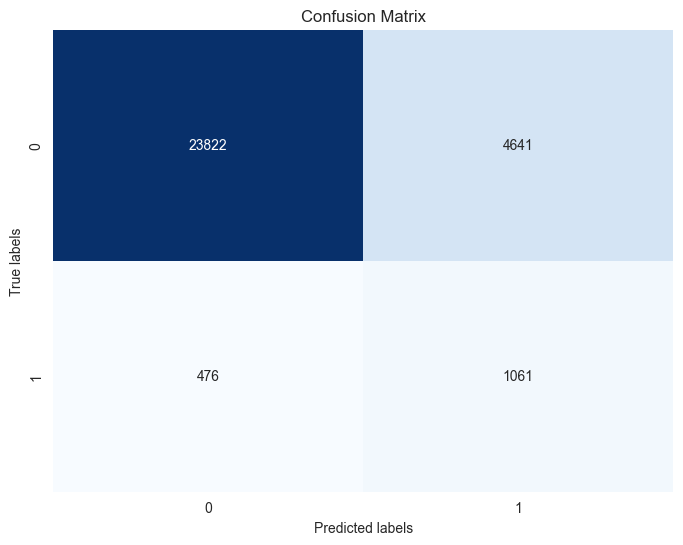

In [71]:
df_test['predicted'] = df_test[prediction_col] >= best_threshold
cm = confusion_matrix(df_test[target_col], df_test['predicted'])
plot_confusion_matrix(cm)

In [5]:
fraud_rate = round(476 / (476 + 23822), 2)
approval_rate = round((476 + 23822) / 30000, 2)

print(f"Taxa de fraude = {fraud_rate}")
print(f"Taxa de aprovação = {approval_rate}")

Taxa de fraude = 0.02
Taxa de aprovação = 0.81


In [73]:
# Converte as probabilidades em classificações binárias com base em um limiar (0.5 é comum)
y_pred_binary = df_test[prediction_col] >= best_threshold

# Calcula as métricas de desempenho
loss = log_loss(y_test, y_pred_binary)
roc_auc = roc_auc_score(y_test, df_test[prediction_col] >= best_threshold)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

# Imprime as métricas de desempenho
print(f'Log Loss: {loss:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'Precisão: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

Log Loss: 5.8913
ROC-AUC: 0.7636
Precisão: 0.19
Recall: 0.69
F1-score: 0.29


In [74]:
mlflow.log_metrics({
    "best_profit": best_profit,
    "best_threshold": best_threshold,
    "Log Loss": loss,
    "ROC-AUC": roc_auc,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1
})

mlflow.end_run()

### SHAP

In [75]:
import shap

tree_model = model.named_steps['classifier']
explainer = shap.TreeExplainer(tree_model)

preprocessing_pipeline = Pipeline(model.steps[:-1])

# Transformando X_test
X_test_transformed = preprocessing_pipeline.transform(X_test)

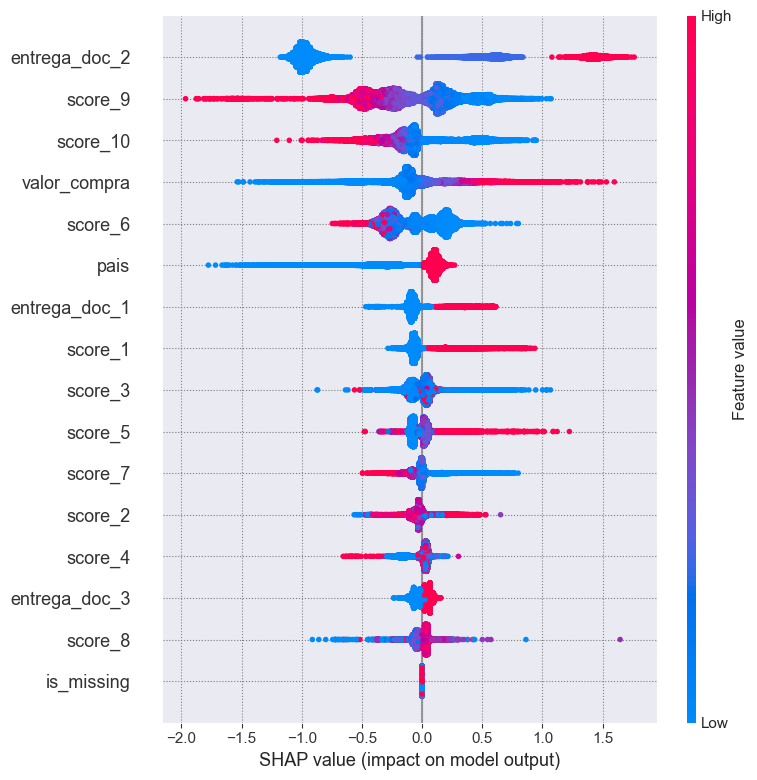

In [76]:
shap_values = explainer.shap_values(X_test_transformed)

# Para visualizar a importância das features
shap.summary_plot(shap_values, X_test_transformed)


### Comparação entre os modelos

# Análise da Diferença em Lucro entre o Modelo Atual e o Modelo Treinado

## Modelo Atual:

| Metrica       | Valor       |
| ------------- | ----------- |
| threshold     | 73.000      |
| fraud_losses  | 25353.320   |
| revenues      | 80329.995   |
| profit        | 54976.675   |

- **Taxa de fraude:** 0.02
- **Taxa de aprovação:** 0.74

**Razão Lucro/Receitas (profit/revenues):** 0.684 (ou 68.4%)

## Modelo Treinado:

| Metrica       | Valor       |
| ------------- | ----------- |
| threshold     | 57.000      |
| fraud_losses  | 23638.960   |
| revenues      | 90147.033   |
| profit        | 66508.073   |

- **Taxa de fraude:** 0.02
- **Taxa de aprovação:** 0.81

**Razão Lucro/Receitas (profit/revenues):** 0.737 (ou 73.7%)




## Valuation dos Modelos Financeiros

Dado o crescimento em pagamentos e a aplicação de modelos preditivos para otimização de lucros, realizamos uma simulação para avaliar o impacto financeiro de transicionar do nosso Modelo Atual para um Modelo Treinado.

## Dados:

- **Volume total de pagamentos em um trimestre:** 20 M (milhões)
- **Valor médio de transação:** R$ 20.61

## Cálculos:

### Receita Mensal

Primeiro, vamos calcular a receita média mensal para esse volume de pagamentos:




In [94]:
volume_total_pagamentos = 20  # em milhões
valor_medio_transacao = (df.valor_compra.median())  # em dolares

receita_mensal = (volume_total_pagamentos * valor_medio_transacao) / 3  # divide por 3 meses em um trimestre
receita_mensal

137.4

### Lucro Mensal do Modelo Atual

Com base na razão lucro/receitas do modelo atual:

In [95]:
razao_lucro_receitas_atual = 0.684  # ou 68.4%

lucro_mensal_atual = razao_lucro_receitas_atual * receita_mensal
lucro_mensal_atual

93.98160000000001


### Lucro Mensal do Modelo Treinado

Para o Modelo Treinado:



In [96]:
razao_lucro_receitas_treinado = 0.737  # ou 73.7%

lucro_mensal_treinado = razao_lucro_receitas_treinado * receita_mensal
lucro_mensal_treinado

101.2638

## Conclusão:

A diferença entre o lucro do Modelo Atual e o Modelo Treinado representa o ganho potencial ao implementarmos o novo modelo:



In [97]:
ganho_potencial = lucro_mensal_treinado - lucro_mensal_atual
ganho_potencial

7.282199999999989


Assim, observamos que a implementação do Modelo Treinado pode trazer um incremento significativo no lucro mensal em comparação com o modelo atual.


## Conclusão Geral:

Após uma análise aprofundada das métricas de desempenho e valuation financeiro de ambos os modelos, os seguintes pontos foram observados:

1. **Métricas de Desempenho**:
    - O **Modelo Treinado** apresentou uma melhoria significativa em várias métricas-chave em comparação ao **Modelo Atual**:
        - **Log Loss** foi reduzido de 8.2526 para 5.8913.
        - **ROC-AUC** aumentou de 0.7193 para 0.7636, sugerindo uma capacidade melhor de discriminação.
        - **Precisão** cresceu de 0.13 para 0.19.
        - **Recall** se manteve relativamente constante, variando de 0.67 para 0.69.
        - **F1-score**, uma métrica que combina precisão e recall, melhorou de 0.22 para 0.29.
        
    Isso sugere que o Modelo Treinado é mais eficiente na identificação e prevenção de fraudes sem sacrificar significativamente as aprovações legítimas.

2. **Performance Financeira**:
    - O **Modelo Treinado** possui uma **Taxa de Aprovação** mais alta de 0.81 (em comparação a 0.74 do Modelo Atual), indicando uma maior aprovação de transações legítimas.
    - A **Razão Lucro/Receitas** para o Modelo Treinado é de 73.7%, uma melhoria notável em relação aos 68.4% do Modelo Atual.
    - Com base em uma simulação usando um volume de pagamento trimestral de 20 M e um valor médio de transação de 20.61, estimamos que a implementação do Modelo Treinado poderia trazer um incremento de aproximadamente 7.28 M no lucro mensal.

3. **Considerações Finais**:
    - A transição para o Modelo Treinado não apenas melhora a eficácia na detecção e prevenção de fraudes, mas também tem o potencial de trazer ganhos financeiros substanciais. A combinação de métricas de desempenho aprimoradas e valuation financeiro favorável sugere que a adoção do Modelo Treinado é uma decisão estratégica sólida para otimizar a operação e maximizar os lucros.
